<font color="#CC3D3D"><p>
# gensim - reproducible training

## EmbeddingVectorzier -W2V

In [1]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
import os
#os.environ["PYTHONHASHSEED"] = "123"


# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
import shap
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

from gensim.models import word2vec
from sklearn.pipeline import Pipeline
from gensim.models import doc2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [2]:
### Read data
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)


In [3]:
### Make corpus: corpus는 말뭉치라는 뜻임

# oversample2: unique사용 X, 비복원추출 -> 복원추출
# data는 X_train 또는 X_test가 될 것
# p_level은 대, 중, 소분류중에 하나 넣기('gds_grp_mclas_nm', 'gds_grp_nm', 'goods_id')
# n은 몇번 오버샘플링 할 것인지 -> 1일때 기본 + 오버샘플링, 2일때 기본 + 오버샘플링2
#                               -> 고객리스트가 10개인데 n값이 1이면 고객리스트를 20개(기본(10) + 오버샘플링(10))로 반환
#                               -> 고객리스트가 10개인데 n값이 2이면 고객리스트를 30개(기본(10) + 오버샘플링(20))로 반환

def oversample2(data, p_level, n=1, seed=0):    
    
    np.random.seed(seed)
    
    cust_ids = data['cust_id'].unique().tolist() 
    
    customerProducts = []
    
    for cust_id in cust_ids:
        
        productLst = data.query(f'cust_id=={cust_id}')[p_level].tolist()
        
        for j in range(n):
   
            productLst = list(np.append(productLst, np.random.choice(productLst, len(productLst) * n, replace=True)))
        
        customerProducts.append(productLst)
    
    return customerProducts

In [4]:
# 중분류 구매목록
print('중분류 구매목록 뽑는중')
X_train_corpus_nm = oversample2(df_train,'gds_grp_nm', 2)
X_test_corpus_nm = oversample2(df_test,'gds_grp_nm', 2)

중분류 구매목록 뽑는중


In [5]:
# 중분류 구매목록
print('중분류 구매목록 뽑는중')
X_train_corpus_mclas_nm = oversample2(df_train,'gds_grp_mclas_nm', 2)
X_test_corpus_mclas_nm = oversample2(df_test,'gds_grp_mclas_nm', 2)

중분류 구매목록 뽑는중


In [6]:
### Training the Word2Vec model
num_features = 300 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 10 # 학습 윈도우(인접한 단어 리스트) 크기

# 중분류
print('중분류 학습중')
w2v_nm = word2vec.Word2Vec(X_train_corpus_nm,                  # 학습시킬 단어 리스트
                        size=num_features,        # 단어 벡터의 차원 수
                        window=context,           # 주변 단어(window)는 안뒤로 몇개까지 볼 것인지
                        min_count=min_word_count, # 단어 리스트에서 출현 빈도가 몇번 미만인 단어는 분석에서 제외해라
                        workers=4,                # cpu는 쿼드코어를 써라 n_jobs=-1과 같음
                        sg = 1,                   # CBOW와 skip-gram중 후자를 선택
                        iter=7,
                        seed=0)

# 필요없는 메모리 unload
w2v_nm.init_sims(replace=True)



# 대분류
print('대분류 학습중')
w2v_mclas_nm = word2vec.Word2Vec(X_train_corpus_mclas_nm,                  # 학습시킬 단어 리스트
                        size=num_features,        # 단어 벡터의 차원 수
                        window=context,           # 주변 단어(window)는 안뒤로 몇개까지 볼 것인지
                        min_count=min_word_count, # 단어 리스트에서 출현 빈도가 몇번 미만인 단어는 분석에서 제외해라
                        workers=4,                # cpu는 쿼드코어를 써라 n_jobs=-1과 같음
                        sg = 1,                   # CBOW와 skip-gram중 후자를 선택
                        iter=7,
                        seed=0)

# 필요없는 메모리 unload
w2v_mclas_nm.init_sims(replace=True)

중분류 학습중
대분류 학습중


In [37]:
### Make features
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기(pipeline에서 사용 가능)
class EmbeddingVectorizer_nm(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.var([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),          
            ]) 
            for words in X
        ])

In [38]:
### Make features
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기(pipeline에서 사용 가능)
class EmbeddingVectorizer_mclas(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),               
            ]) 
            for words in X
        ])

In [39]:
# EmbeddingVectorizer 클래스를 통해서 피쳐뽑기(std, max, var -> 600개 피쳐나옴)

# 중분류
Vectorizer = EmbeddingVectorizer_nm(w2v_nm.wv)
Vectorizer.fit(X_train_corpus_nm, y_train)

X_train_nm = pd.DataFrame(Vectorizer.transform(X_train_corpus_nm))
X_test_nm = pd.DataFrame(Vectorizer.transform(X_test_corpus_nm))

display(X_train_nm)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599
0,5.899665e-02,5.280996e-02,4.896489e-02,4.692144e-02,5.887605e-02,3.703730e-02,4.528708e-02,0.056775,4.558063e-02,4.952119e-02,5.959244e-02,4.511775e-02,5.462449e-02,4.705761e-02,0.061487,5.883342e-02,2.512778e-02,4.515208e-02,4.507128e-02,0.050417,0.037349,4.976974e-02,4.951488e-02,3.703742e-02,4.567186e-02,...,1.574418e-03,0.001319,3.143304e-03,2.444613e-03,1.740517e-03,1.516745e-03,1.770055e-03,1.947633e-03,3.297247e-03,2.333472e-03,1.856221e-03,2.957339e-03,2.467760e-03,0.002445,1.625690e-03,1.224367e-03,2.851567e-03,2.913763e-03,1.396872e-03,1.971637e-03,3.328197e-03,6.305944e-04,3.293653e-03,1.796263e-03,2.773332e-03
1,4.440968e-02,3.742162e-02,5.923415e-02,2.783321e-02,2.523422e-02,7.106266e-03,3.267865e-02,0.005263,2.856833e-02,7.226545e-02,2.235206e-02,9.817278e-03,2.250186e-02,1.426914e-02,0.024142,2.960102e-02,2.988188e-02,1.449286e-02,5.052224e-02,0.012466,0.006994,1.225173e-03,3.484410e-02,7.933024e-02,5.527479e-02,...,3.662446e-03,0.000111,1.075966e-03,2.372451e-03,8.138143e-05,5.958367e-04,1.640622e-03,1.508940e-05,5.193969e-03,1.134303e-03,1.997741e-06,2.317969e-04,7.422026e-04,0.000856,3.781574e-04,2.086106e-03,3.834549e-04,2.802663e-03,1.529549e-03,1.009608e-03,2.277989e-03,2.949831e-03,8.593599e-05,1.258057e-04,2.066553e-04
2,3.381081e-02,8.462013e-03,8.081478e-02,3.126807e-03,3.733460e-02,4.156350e-02,6.252491e-02,0.003031,3.383411e-02,2.499662e-02,1.678573e-02,1.322571e-02,1.331047e-02,1.990806e-02,0.026797,4.470570e-02,5.285054e-03,3.717316e-02,9.725036e-03,0.000963,0.000839,7.777274e-03,4.730411e-02,2.759685e-03,2.173524e-02,...,1.224733e-05,0.000030,2.512346e-03,1.818921e-07,2.093467e-05,7.464849e-05,5.743853e-04,1.393299e-03,6.052887e-05,2.655292e-05,1.461139e-03,2.393817e-07,3.698634e-04,0.004825,7.498065e-04,3.711137e-04,2.809115e-04,5.435319e-05,2.141200e-03,2.454248e-04,2.295564e-04,9.673846e-04,2.244568e-04,2.840670e-03,7.394465e-04
3,4.476567e-02,3.724468e-02,6.270374e-02,3.711123e-02,4.323265e-02,3.776972e-02,3.849525e-02,0.041409,2.866256e-02,4.330871e-02,5.383167e-02,3.393687e-02,4.525302e-02,2.844671e-02,0.029419,5.589782e-02,2.943322e-02,3.370453e-02,3.045639e-02,0.040457,0.046573,4.675895e-02,2.942423e-02,4.083059e-02,3.134383e-02,...,1.083091e-03,0.001145,1.644589e-03,1.503822e-03,1.313847e-03,7.891656e-04,1.031037e-03,9.773326e-04,1.304195e-03,1.730070e-03,2.918254e-03,1.161793e-03,1.223623e-03,0.001724,1.076595e-03,8.737850e-04,1.346725e-03,1.344919e-03,1.572815e-03,2.171269e-03,7.643650e-04,9.773914e-04,2.094978e-03,1.871777e-03,1.908531e-03
4,6.251881e-02,2.899562e-02,1.460668e-02,6.149970e-02,4.184485e-02,5.260567e-02,4.462630e-02,0.063573,3.777427e-02,4.822346e-02,6.022044e-02,2.236826e-02,2.380999e-02,1.820231e-02,0.046688,5.210932e-02,1.958533e-02,2.550013e-02,1.182246e-02,0.022583,0.020502,5.179163e-02,5.374951e-02,2.011977e-02,7.367784e-02,...,9.113579e-05,0.001637,1.904305e-03,4.166640e-04,1.305549e-03,1.371052e-04,8.406171e-05,6.956834e-04,2.633089e-03,3.773385e-03,2.137582e-03,1.697902e-03,2.647801e-03,0.001237,1.481885e-03,6.407175e-04,1.624784e-03,4.444869e-04,4.277814e-04,4.366288e-03,1.543152e-03,6.034404e-04,4.013900e-03,2.426057e-03,3.381427e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4.867327e-03,1.004821e-02,1.841670e-03,1.046062e-02,1.225543e-02,3.247649e-02,3.132902e-03,0.016049,3.362139e-02,8.664630e-02,6.594805e-03,1.763941e-02,5.992286e-02,1.350976e-02,0.029732,2.829801e-02,7.291049e-03,9.632668e-03,1.842618e-02,0.045679,0.010909,1.522550e-03,1.179132e-02,1.487208e-02,5.360587e-03,...,6.825340e-05,0.000539,9.064272e-04,6.238247e-06,2.082344e-03,5.249595e-06,1.328041e-03,7.003818e-04,9.346841e-05,4.201675e-04,1.118225e-03,4.030

In [40]:
# EmbeddingVectorizer 클래스를 통해서 피쳐뽑기(std, max, var -> 600개 피쳐나옴)

# 중분류
Vectorizer = EmbeddingVectorizer_mclas(w2v_mclas_nm.wv)
Vectorizer.fit(X_train_corpus_mclas_nm, y_train)

X_train_mclas = pd.DataFrame(Vectorizer.transform(X_train_corpus_mclas_nm))
X_test_mclas = pd.DataFrame(Vectorizer.transform(X_test_corpus_mclas_nm))

display(X_train_mclas)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599
0,0.174072,0.265981,0.196587,0.096481,0.099925,0.046536,0.145079,0.066760,-0.007020,0.168740,0.088188,0.166307,0.110887,0.148301,0.126536,0.116817,0.111467,0.071353,0.043774,0.026025,0.119931,0.055466,0.114719,0.020517,0.084407,...,-0.038545,-0.045669,-0.055630,-0.037056,-0.005578,-0.134003,-0.113941,-0.009877,-0.050500,-0.000547,-0.122575,-0.146007,-0.141444,-0.132639,-0.108260,-0.120854,-0.149144,-0.071311,-0.115175,-0.067119,-0.140706,-0.156888,-0.105949,-0.155277,-0.097476
1,0.174072,0.068778,0.111550,-0.012871,0.001516,-0.039886,-0.036712,-0.080081,-0.033167,0.058489,-0.080515,0.128807,-0.114568,0.037071,0.095024,0.023751,0.100521,-0.046796,0.036276,0.056122,0.112722,-0.029817,0.114719,-0.058567,0.042525,...,-0.002597,-0.045669,-0.052208,-0.037056,0.033387,-0.134003,-0.043292,-0.004148,-0.013518,-0.000547,-0.122575,-0.032768,-0.083895,-0.006223,-0.072234,0.009968,-0.049314,-0.069718,-0.115175,-0.027768,-0.055288,-0.156888,-0.077582,-0.129688,-0.097476
2,0.055372,0.096409,0.163944,-0.088123,0.090492,0.003906,-0.063314,-0.082616,-0.042864,0.060331,-0.022070,0.086318,-0.059094,0.077486,0.033817,0.063505,-0.003999,0.018516,-0.009062,-0.018945,0.080621,-0.161764,0.004137,-0.142002,0.052934,...,-0.006532,0.054809,-0.018034,0.068633,0.062244,-0.060017,-0.011618,0.032686,-0.020462,0.038383,-0.084510,-0.021785,-0.056942,-0.072221,-0.014983,-0.102819,-0.053004,0.066322,-0.069749,-0.038525,-0.066701,-0.007472,-0.013615,-0.054837,-0.013450
3,0.171762,0.265981,0.199456,0.131196,0.099925,0.046536,0.073278,0.006064,-0.020572,0.098154,0.088188,0.114986,-0.001317,0.153721,0.126536,0.116817,0.109793,0.111261,0.052623,0.045553,0.126636,0.030160,0.048697,-0.004195,0.052404,...,-0.119549,-0.041610,-0.043324,-0.004938,-0.053267,-0.086869,-0.044628,-0.001354,-0.061431,-0.029203,-0.051993,-0.094488,-0.074514,-0.153757,-0.085044,-0.031864,-0.150555,-0.012360,-0.158937,-0.065705,-0.140706,-0.168466,-0.090018,-0.140302,-0.138996
4,-0.015664,0.086521,0.196587,0.071572,0.138723,0.025781,0.089407,0.019994,-0.063460,0.065836,0.009255,0.086318,-0.040535,0.077486,0.086951,0.063505,0.046573,0.060936,0.035527,0.005742,0.094007,-0.063334,0.004137,-0.023609,0.034474,...,-0.112550,-0.067836,-0.030535,0.008223,-0.039555,-0.060017,-0.024177,0.028466,-0.072115,-0.016811,-0.007957,-0.048255,-0.059653,-0.072221,-0.066115,-0.067482,-0.149144,0.023247,-0.137172,-0.038525,-0.066701,-0.090533,-0.098720,-0.181164,-0.156407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.014302,0.209121,0.163944,0.046801,0.090492,-0.067673,0.062928,-0.082616,-0.133171,0.060331,-0.022070,0.094674,-0.059094,0.077486,0.094752,0.063505,-0.003999,0.018516,0.004844,0.017444,0.116418,-0.149704,0.004137,-0.124536,0.034474,...,-0.006532,-0.038256,-0.055630,0.013785,0.071736,-0.107622,-0.050094,0.062155,-0.020462,0.049505,-0.117031,-0.021785,-0.113334,-0.072221,-0.056760,0.002338,-0.053004,0.012324,-0.069749,-0.038525,-0.066701,-0.051577,-0.028605,-0.021961,-0.013450
3496,0.141686,0.209121,0.163944,0.057009,0.090492,0.011961,0.062928,0.066760,-0.007020,0.060331,0.073274,0.094674,0.110887,0.077486,0.094752,0.089874,-0.003999,0.075278,0.022696,0.017444,0.116418,0.055466,0.051925,-0.004195,0.034474,...,-0.019617,-0.038256,-0.055630,0.013785,-0.005578,-0.107622,-0.090470,-0.009877,-0.020462,0.033123,-0.117031,-0.146007,-0.113334,-0.127022,-0.056760,-0.120854,-0.150555,-0.019719,-0.069749,-0.038525,-0.069173,-0.069092,-0.065742,-0.117108,-0.093929
3497,0.019395,0.248692,0.135810,-0.086261,0.101844,0.155013,0.004018,-0.031502,-0.079604,0.053163,0.047263,-0.025547,-0.177609,-0.016193,-0.018588,0.025897,0.083235,0.034429,0.041179,-0.020719,0.201592,-0.202029,-0.008488,-0.13

In [41]:
mix = pd.concat([X_train_nm, X_train_mclas], axis=1); mix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599
0,5.899665e-02,5.280996e-02,4.896489e-02,4.692144e-02,5.887605e-02,3.703730e-02,4.528708e-02,0.056775,4.558063e-02,4.952119e-02,5.959244e-02,4.511775e-02,5.462449e-02,4.705761e-02,0.061487,5.883342e-02,2.512778e-02,4.515208e-02,4.507128e-02,0.050417,0.037349,4.976974e-02,4.951488e-02,3.703742e-02,4.567186e-02,...,-0.038545,-0.045669,-0.055630,-0.037056,-0.005578,-0.134003,-0.113941,-0.009877,-0.050500,-0.000547,-0.122575,-0.146007,-0.141444,-0.132639,-0.108260,-0.120854,-0.149144,-0.071311,-0.115175,-0.067119,-0.140706,-0.156888,-0.105949,-0.155277,-0.097476
1,4.440968e-02,3.742162e-02,5.923415e-02,2.783321e-02,2.523422e-02,7.106266e-03,3.267865e-02,0.005263,2.856833e-02,7.226545e-02,2.235206e-02,9.817278e-03,2.250186e-02,1.426914e-02,0.024142,2.960102e-02,2.988188e-02,1.449286e-02,5.052224e-02,0.012466,0.006994,1.225173e-03,3.484410e-02,7.933024e-02,5.527479e-02,...,-0.002597,-0.045669,-0.052208,-0.037056,0.033387,-0.134003,-0.043292,-0.004148,-0.013518,-0.000547,-0.122575,-0.032768,-0.083895,-0.006223,-0.072234,0.009968,-0.049314,-0.069718,-0.115175,-0.027768,-0.055288,-0.156888,-0.077582,-0.129688,-0.097476
2,3.381081e-02,8.462013e-03,8.081478e-02,3.126807e-03,3.733460e-02,4.156350e-02,6.252491e-02,0.003031,3.383411e-02,2.499662e-02,1.678573e-02,1.322571e-02,1.331047e-02,1.990806e-02,0.026797,4.470570e-02,5.285054e-03,3.717316e-02,9.725036e-03,0.000963,0.000839,7.777274e-03,4.730411e-02,2.759685e-03,2.173524e-02,...,-0.006532,0.054809,-0.018034,0.068633,0.062244,-0.060017,-0.011618,0.032686,-0.020462,0.038383,-0.084510,-0.021785,-0.056942,-0.072221,-0.014983,-0.102819,-0.053004,0.066322,-0.069749,-0.038525,-0.066701,-0.007472,-0.013615,-0.054837,-0.013450
3,4.476567e-02,3.724468e-02,6.270374e-02,3.711123e-02,4.323265e-02,3.776972e-02,3.849525e-02,0.041409,2.866256e-02,4.330871e-02,5.383167e-02,3.393687e-02,4.525302e-02,2.844671e-02,0.029419,5.589782e-02,2.943322e-02,3.370453e-02,3.045639e-02,0.040457,0.046573,4.675895e-02,2.942423e-02,4.083059e-02,3.134383e-02,...,-0.119549,-0.041610,-0.043324,-0.004938,-0.053267,-0.086869,-0.044628,-0.001354,-0.061431,-0.029203,-0.051993,-0.094488,-0.074514,-0.153757,-0.085044,-0.031864,-0.150555,-0.012360,-0.158937,-0.065705,-0.140706,-0.168466,-0.090018,-0.140302,-0.138996
4,6.251881e-02,2.899562e-02,1.460668e-02,6.149970e-02,4.184485e-02,5.260567e-02,4.462630e-02,0.063573,3.777427e-02,4.822346e-02,6.022044e-02,2.236826e-02,2.380999e-02,1.820231e-02,0.046688,5.210932e-02,1.958533e-02,2.550013e-02,1.182246e-02,0.022583,0.020502,5.179163e-02,5.374951e-02,2.011977e-02,7.367784e-02,...,-0.112550,-0.067836,-0.030535,0.008223,-0.039555,-0.060017,-0.024177,0.028466,-0.072115,-0.016811,-0.007957,-0.048255,-0.059653,-0.072221,-0.066115,-0.067482,-0.149144,0.023247,-0.137172,-0.038525,-0.066701,-0.090533,-0.098720,-0.181164,-0.156407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4.867327e-03,1.004821e-02,1.841670e-03,1.046062e-02,1.225543e-02,3.247649e-02,3.132902e-03,0.016049,3.362139e-02,8.664630e-02,6.594805e-03,1.763941e-02,5.992286e-02,1.350976e-02,0.029732,2.829801e-02,7.291049e-03,9.632668e-03,1.842618e-02,0.045679,0.010909,1.522550e-03,1.179132e-02,1.487208e-02,5.360587e-03,...,-0.006532,-0.038256,-0.055630,0.013785,0.071736,-0.107622,-0.050094,0.062155,-0.020462,0.049505,-0.117031,-0.021785,-0.113334,-0.072221,-0.056760,0.002338,-0.053004,0.012324,-0.069749,-0.038525,-0.066701,-0.051577,-0.028605,-0.021961,-0.013450
3496,4.646836e-02,7.465217e-02,3.738804e-02,2.867129e-02,2.526517e-02,2.221232e-02,5.093722e-02,0.046614,3.622800e-02,5.158681e-02,8.424698e-02,1.986091e-02,6.063771e-02,7.796669e-02,0.050515,5.133567e-02,3.175574e-02,3.903417e-02,5.288789e-02,0.

In [47]:
X_test_mix = pd.concat([X_test_nm, X_test_mclas], axis=1)

In [55]:
X_test_w2v = X_test_w2v.reset_index().drop('cust_id', axis=1)

In [61]:
X_test_experiment = pd.concat([X_test_mix, X_test_w2v], axis=1)

In [42]:
## X_train_w2v 과 합치기

X_train_experiment = pd.concat([mix, X_train_w2v], axis=1)
X_train_experiment

# X_test_nm['cust_id'] = range(3500, 5982)
# X_test_w2v = X_test_w2v.reset_index()
# X_test_experiment = pd.merge(X_test_nm, X_test_w2v, on='cust_id')
# X_test_experiment = X_test_experiment.drop('cust_id', axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,goods_0_similarity,goods_1_similarity,nm_0_similarity,nm_1_similarity,mclas_0_similarity,mclas_1_similarity
0,5.899665e-02,5.280996e-02,4.896489e-02,4.692144e-02,5.887605e-02,3.703730e-02,4.528708e-02,0.056775,4.558063e-02,4.952119e-02,5.959244e-02,4.511775e-02,5.462449e-02,4.705761e-02,0.061487,5.883342e-02,2.512778e-02,4.515208e-02,4.507128e-02,0.050417,0.037349,4.976974e-02,4.951488e-02,3.703742e-02,4.567186e-02,...,-0.113941,-0.009877,-0.050500,-0.000547,-0.122575,-0.146007,-0.141444,-0.132639,-0.108260,-0.120854,-0.149144,-0.071311,-0.115175,-0.067119,-0.140706,-0.156888,-0.105949,-0.155277,-0.097476,0.177814,0.056659,0.250375,0.015539,0.103248,-0.034322
1,4.440968e-02,3.742162e-02,5.923415e-02,2.783321e-02,2.523422e-02,7.106266e-03,3.267865e-02,0.005263,2.856833e-02,7.226545e-02,2.235206e-02,9.817278e-03,2.250186e-02,1.426914e-02,0.024142,2.960102e-02,2.988188e-02,1.449286e-02,5.052224e-02,0.012466,0.006994,1.225173e-03,3.484410e-02,7.933024e-02,5.527479e-02,...,-0.043292,-0.004148,-0.013518,-0.000547,-0.122575,-0.032768,-0.083895,-0.006223,-0.072234,0.009968,-0.049314,-0.069718,-0.115175,-0.027768,-0.055288,-0.156888,-0.077582,-0.129688,-0.097476,-0.178935,0.045230,-0.403775,0.367147,-0.165190,0.053595
2,3.381081e-02,8.462013e-03,8.081478e-02,3.126807e-03,3.733460e-02,4.156350e-02,6.252491e-02,0.003031,3.383411e-02,2.499662e-02,1.678573e-02,1.322571e-02,1.331047e-02,1.990806e-02,0.026797,4.470570e-02,5.285054e-03,3.717316e-02,9.725036e-03,0.000963,0.000839,7.777274e-03,4.730411e-02,2.759685e-03,2.173524e-02,...,-0.011618,0.032686,-0.020462,0.038383,-0.084510,-0.021785,-0.056942,-0.072221,-0.014983,-0.102819,-0.053004,0.066322,-0.069749,-0.038525,-0.066701,-0.007472,-0.013615,-0.054837,-0.013450,-0.432448,0.273241,0.068090,0.392857,-0.038744,0.191552
3,4.476567e-02,3.724468e-02,6.270374e-02,3.711123e-02,4.323265e-02,3.776972e-02,3.849525e-02,0.041409,2.866256e-02,4.330871e-02,5.383167e-02,3.393687e-02,4.525302e-02,2.844671e-02,0.029419,5.589782e-02,2.943322e-02,3.370453e-02,3.045639e-02,0.040457,0.046573,4.675895e-02,2.942423e-02,4.083059e-02,3.134383e-02,...,-0.044628,-0.001354,-0.061431,-0.029203,-0.051993,-0.094488,-0.074514,-0.153757,-0.085044,-0.031864,-0.150555,-0.012360,-0.158937,-0.065705,-0.140706,-0.168466,-0.090018,-0.140302,-0.138996,0.249025,0.071677,0.290123,0.167954,0.145361,0.077248
4,6.251881e-02,2.899562e-02,1.460668e-02,6.149970e-02,4.184485e-02,5.260567e-02,4.462630e-02,0.063573,3.777427e-02,4.822346e-02,6.022044e-02,2.236826e-02,2.380999e-02,1.820231e-02,0.046688,5.210932e-02,1.958533e-02,2.550013e-02,1.182246e-02,0.022583,0.020502,5.179163e-02,5.374951e-02,2.011977e-02,7.367784e-02,...,-0.024177,0.028466,-0.072115,-0.016811,-0.007957,-0.048255,-0.059653,-0.072221,-0.066115,-0.067482,-0.149144,0.023247,-0.137172,-0.038525,-0.066701,-0.090533,-0.098720,-0.181164,-0.156407,0.145374,0.031926,0.343873,-0.101595,0.084465,-0.067709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4.867327e-03,1.004821e-02,1.841670e-03,1.046062e-02,1.225543e-02,3.247649e-02,3.132902e-03,0.016049,3.362139e-02,8.664630e-02,6.594805e-03,1.763941e-02,5.992286e-02,1.350976e-02,0.029732,2.829801e-02,7.291049e-03,9.632668e-03,1.842618e-02,0.045679,0.010909,1.522550e-03,1.179132e-02,1.487208e-02,5.360587e-03,...,-0.050094,0.062155,-0.020462,0.049505,-0.117031,-0.021785,-0.113334,-0.072221,-0.056760,0.002338,-0.053004,0.012324,-0.069749,-0.038525,-0.066701,-0.051577,-0.028605,-0.021961,-0.013450,-0.134686,-0.004379,0.222717,0.121438,0.043792,0.042025
3496,4.646836e-02,7.465217e-02,3.738804e-02,2.867129e-02,2.526517e-02,2.221232e-02,5.093722e-02,0.046614,3.622800e-02,5.158681e-02,8.424698e-02,1.986091e-02,6.063771e-02,7.796669e-0

In [43]:
# 피쳐 성능 찍어보기
logreg = LogisticRegression(random_state=0, n_jobs=-1)
lgbm = LGBMClassifier(n_jobs=-1, random_state=0)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

models = [logreg, lgbm, rf]

In [44]:
for model in models:
    
    cv_scores = cross_val_score(model, X_train_experiment, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    print(model.__class__.__name__,cv_scores)
    print('최대성능 :', max(cv_scores))
    print('평균성능 :', np.mean(cv_scores))

LogisticRegression [0.76526715 0.76413708 0.76165425 0.76329926]
최대성능 : 0.765267154324905
평균성능 : 0.7635894374116259
LGBMClassifier [0.74065878 0.74328078 0.75785764 0.75496009]
최대성능 : 0.757857643875881
평균성능 : 0.7491893238473785
RandomForestClassifier [0.74516795 0.75348208 0.74321398 0.73218322]
최대성능 : 0.7534820802298007
평균성능 : 0.7435118073415946


성능찍어보기: 중분류 2개 대분류2개 -> 1200개로 돌리기
중분류 1등: max, std, var
대분류 1등: max, min, mean

<중: max, std, 대: max, min>
LogisticRegression [0.76992663 0.75743456 0.75849783 0.76855996]
최대성능 : 0.7699266285892425
평균성능 : 0.7636047463175122
LGBMClassifier [0.755681   0.74629803 0.74626741 0.74988031]
최대성능 : 0.7556809958025764
평균성능 : 0.7495316866517474
RandomForestClassifier [0.74971052 0.73923088 0.72889876 0.74532383]
최대성능 : 0.7497105225068751
평균성능 : 0.740790997249964

<중: max, std, 대: max, mean>
LogisticRegression [0.77253749 0.75830299 0.75646593 0.76409533]
최대성능 : 0.7725374929022345
평균성능 : 0.7628504347729271
LGBMClassifier [0.74311934 0.74062538 0.74917054 0.76151786]
최대성능 : 0.7615178641014507
평균성능 : 0.7486082812830532
RandomForestClassifier [0.74597237 0.73305722 0.73995179 0.73084717]
최대성능 : 0.7459723660331563
평균성능 : 0.737457135063518

<중: max, std, 대: min, mean>
LogisticRegression [0.76882439 0.7575459  0.75402207 0.76588786]
최대성능 : 0.7688243873654208
평균성능 : 0.7615700535533363
LGBMClassifier [0.74081187 0.75114399 0.75136945 0.75075988]
최대성능 : 0.7513694512174754
평균성능 : 0.7485212988632441
RandomForestClassifier [0.7454964  0.73612735 0.74676286 0.72545843]
최대성능 : 0.746762862264382
평균성능 : 0.7384612601177951

<중: max, var, 대: max, min>
LogisticRegression [0.7710233  0.75731487 0.75814434 0.76838739]
최대성능 : 0.7710233029381965
평균성능 : 0.7637174755335848
LGBMClassifier [0.74741975 0.73820101 0.75056225 0.7477649 ]
최대성능 : 0.7505622543616465
평균성능 : 0.7459869790796843
RandomForestClassifier [0.74900631 0.74158289 0.73368349 0.7423706 ]
최대성능 : 0.7490063128361001
평균성능 : 0.7416608214480556

<중: max, var, 대: max, mean>
LogisticRegression [0.77405168 0.75734549 0.75587027 0.7650751 ]
최대성능 : 0.7740516828662726
평균성능 : 0.7630856352360912
LGBMClassifier [0.75456762 0.74783727 0.75558636 0.76029872]
최대성능 : 0.7602987185054054
평균성능 : 0.7545724918445283
RandomForestClassifier [0.74531269 0.73928377 0.7367564  0.73292639]
최대성능 : 0.7453126913613235
평균성능 : 0.7385698141777168

<중: max, var, 대: min, mean>
LogisticRegression [0.77080063 0.75686117 0.75246891 0.76605487]
최대성능 : 0.7708006279434851
평균성능 : 0.7615463943351481
LGBMClassifier [0.74553815 0.75020597 0.75011969 0.75483205]
최대성능 : 0.7548320473852389
평균성능 : 0.7501739648396183
RandomForestClassifier [0.74541011 0.7400687  0.74809056 0.72336807]
최대성능 : 0.7480905619203492
평균성능 : 0.739234359865059

<중: std, var, 대: max, min>
LogisticRegression [0.76684258 0.75738446 0.76168765 0.7651419 ]
최대성능 : 0.7668425799124887
평균성능 : 0.7627641482124765
LGBMClassifier [0.76713762 0.74069775 0.751748   0.74511228]
최대성능 : 0.7671376242804814
평균성능 : 0.7511739147377445
RandomForestClassifier [0.73430976 0.73682877 0.73775009 0.74123496]
최대성능 : 0.7412349555206699
평균성능 : 0.7375308961555163

<중: std, var, 대: max, mean>
LogisticRegression [0.76857944 0.75739003 0.7621497  0.75911297]
최대성능 : 0.7685794448712383
평균성능 : 0.7618080374539342
LGBMClassifier [0.75092688 0.74709687 0.74836612 0.74970217]
최대성능 : 0.7509268846654864
평균성능 : 0.7490230134607034
RandomForestClassifier [0.74299965 0.73496665 0.73665898 0.73060222]
최대성능 : 0.7429996548537581
평균성능 : 0.7363068795439615

<중: std, var, 대: min, mean>
LogisticRegression [0.76327978 0.75436721 0.75884298 0.76455181]
최대성능 : 0.7645518109043945
평균성능 : 0.7602604462406894
LGBMClassifier [0.75932452 0.74326965 0.75140564 0.74971887]
최대성능 : 0.7593245154035428
평균성능 : 0.7509296681029205
RandomForestClassifier [0.74215071 0.73361112 0.73510304 0.73108654]
최대성능 : 0.7421507064364208
평균성능 : 0.7354878530790385

생각보다 성능이 되게 안정적임

<중: max, var, 대: max, mean>
LogisticRegression [0.77405168 0.75734549 0.75587027 0.7650751 ]
최대성능 : 0.7740516828662726
평균성능 : 0.7630856352360912
LGBMClassifier [0.75456762 0.74783727 0.75558636 0.76029872]
최대성능 : 0.7602987185054054
평균성능 : 0.7545724918445283
RandomForestClassifier [0.74531269 0.73928377 0.7367564  0.73292639]
최대성능 : 0.7453126913613235
평균성능 : 0.7385698141777168

<중: std, var, 대: max, min>
LogisticRegression [0.76684258 0.75738446 0.76168765 0.7651419 ]
최대성능 : 0.7668425799124887
평균성능 : 0.7627641482124765
LGBMClassifier [0.76713762 0.74069775 0.751748   0.74511228]
최대성능 : 0.7671376242804814
평균성능 : 0.7511739147377445
RandomForestClassifier [0.73430976 0.73682877 0.73775009 0.74123496]
최대성능 : 0.7412349555206699
평균성능 : 0.7375308961555163



채택

<중: std, var, 대: max, mean>
LogisticRegression [0.76857944 0.75739003 0.7621497  0.75911297]
최대성능 : 0.7685794448712383
평균성능 : 0.7618080374539342
LGBMClassifier [0.75092688 0.74709687 0.74836612 0.74970217]
최대성능 : 0.7509268846654864
평균성능 : 0.7490230134607034
RandomForestClassifier [0.74299965 0.73496665 0.73665898 0.73060222]
최대성능 : 0.7429996548537581
평균성능 : 0.7363068795439615


## Products Similarity - W2V

In [7]:
### Read data
# y_train에서 .gender 지워준거 말고 다 같음

df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv')
IDtest = df_test.cust_id.unique()


y_train.gender = y_train.gender.astype(str)

tr = pd.merge(df_train, y_train, on='cust_id')
tr2 = pd.concat([df_train, df_test])
y_train = y_train.gender

skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=0)

In [8]:
# 말뭉치(corpus) 제작전 뽑기

before_corpus_goods = []
before_corpus_nm = []
before_corpus_mclas = []

for i in range(len(tr)):
    
    goods = tr.loc[i, 'goods_id']
    nm = tr.loc[i, 'gds_grp_nm']
    mclas = tr.loc[i, 'gds_grp_mclas_nm']
    gender = tr.loc[i, 'gender']
    
    before_corpus_goods.append([goods, gender])
    before_corpus_nm.append([nm, gender])
    before_corpus_mclas.append([mclas, gender])
    
# 말뭉치 만들 칼럼 넣기
tr['before_corpus_goods'] = before_corpus_goods
tr['before_corpus_nm'] = before_corpus_nm
tr['before_corpus_mclas'] = before_corpus_mclas

In [9]:
# 말뭉치 칼럼 제작, 말뭉치 단어 몇개들어가 있는지

corpus_df = pd.DataFrame(tr.groupby('cust_id')['before_corpus_goods'].agg(lambda x: [j for i in x for j in i]))
corpus_df['before_corpus_nm'] = tr.groupby('cust_id')['before_corpus_nm'].agg(lambda x: [j for i in x for j in i])
corpus_df['before_corpus_mclas'] = tr.groupby('cust_id')['before_corpus_mclas'].agg(lambda x: [j for i in x for j in i])

display(corpus_df)

corpus1 = corpus_df['before_corpus_goods']
corpus2 = corpus_df['before_corpus_nm']
corpus3 = corpus_df['before_corpus_mclas']


,before_corpus_goods,before_corpus_nm,before_corpus_mclas
cust_id,,,
0,"[127105, 0, 342220, 0, 127105, 0, 342205, 0, 3...","[기초 화장품, 0, 니 트, 0, 기초 화장품, 0, 니 트, 0, 상품군미지...","[화장품, 0, 시티웨어, 0, 화장품, 0, 시티웨어, 0, 기타, 0, 화장품,..."
1,"[550231, 0, 550231, 0, 462102, 0]","[아웃도아, 0, 아웃도아, 0, 트래디셔널Ⅰ, 0]","[스포츠, 0, 스포츠, 0, 트래디셔널, 0]"
2,"[461119, 1, 461119, 1, 461119, 1, 461119, 1]","[시티캐주얼, 1, 상품군미지정, 1, 상품군미지정, 1, 시티캐주얼, 1]","[남성 캐주얼, 1, 기타, 1, 기타, 1, 남성 캐주얼, 1]"
3,"[35145, 1, 821104, 1, 32263, 1, 50114, 1, 5010...","[회, 1, 한실침구, 1, 생선, 1, 일반가공식품, 1, 일반가공식품, 1, 일...","[수산품, 1, 침구/수예, 1, 수산품, 1, 가공식품, 1, 가공식품, 1, 가..."
4,"[127109, 0, 150124, 0, 150124, 0]","[기초 화장품, 0, 상품군미지정, 0, 보석, 0]","[화장품, 0, 기타, 0, 보석, 0]"
...,...,...,...
3495,"[143102, 1, 143102, 1]","[L/C골프의류, 1, 상품군미지정, 1]","[골프, 1, 기타, 1]"
3496,"[405107, 1, 173197, 1, 381116, 1, 996101, 1, 3...","[N.B정장, 1, 캐릭터 여화, 1, 시니어, 1, 상품군미지정, 1, 인텔리젼스...","[남성정장, 1, 구두, 1, 시티웨어, 1, 기타, 1, 시티웨어, 1, 시티웨어..."
3497,"[647178, 0]","[국산주방, 0]","[주방용품, 0]"


In [10]:
def oversample3(data, n=1, seed=0):    
    
    np.random.seed(seed)
    
    customerProducts = []
    
    for cor in data:
            
        cor = list(np.append(cor, np.random.choice(cor, len(cor) * n, replace=True)))
        
        customerProducts.append(cor)
    
    return customerProducts

In [11]:
corpus1_oversample = oversample3(corpus1, n=20, seed=0)
corpus2_oversample = oversample3(corpus2, n=20, seed=0)
corpus3_oversample = oversample3(corpus3, n=20, seed=0)

In [12]:
# W2V 학습

num_features = 20 # 문자 벡터 차원 수
min_word_count = 0 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기

print('첫번째 w2v모델 학습 진행')
wv_model1 = word2vec.Word2Vec(corpus1_oversample, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)
print('두번째 w2v모델 학습 진행')
wv_model2 = word2vec.Word2Vec(corpus2_oversample, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)
print('세번째 w2v모델 학습 진행')
wv_model3 = word2vec.Word2Vec(corpus3_oversample, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)


첫번째 w2v모델 학습 진행
두번째 w2v모델 학습 진행
세번째 w2v모델 학습 진행


In [13]:
wv_model1.most_similar(positive ='0', negative = '1', topn = 25)

[('303205', 0.6684872508049011),
 ('303103', 0.6615864038467407),
 ('127141', 0.6461789608001709),
 ('303203', 0.6285282373428345),
 ('303204', 0.5793644189834595),
 ('303104', 0.5694666504859924),
 ('303105', 0.5650014877319336),
 ('740115', 0.5561138987541199),
 ('303126', 0.5547641515731812),
 ('303118', 0.5520941019058228),
 ('241110', 0.5515190958976746),
 ('322211', 0.5509201884269714),
 ('111144', 0.5494435429573059),
 ('322111', 0.5388120412826538),
 ('740113', 0.532150387763977),
 ('740133', 0.5243557095527649),
 ('205125', 0.5234799385070801),
 ('173127', 0.5216785073280334),
 ('303246', 0.5185381174087524),
 ('47145', 0.5131843090057373),
 ('342232', 0.5065068006515503),
 ('740178', 0.5063894987106323),
 ('125156', 0.502410352230072),
 ('743269', 0.49973243474960327),
 ('740233', 0.49949532747268677)]

In [14]:
wv_model1.most_similar(positive ='1', negative = '0', topn = 25)

[('405207', 0.6738322377204895),
 ('443209', 0.6535471081733704),
 ('708296', 0.6503934860229492),
 ('448112', 0.6330689191818237),
 ('48190', 0.630981981754303),
 ('173280', 0.6292654871940613),
 ('102277', 0.6104342937469482),
 ('406123', 0.5874328017234802),
 ('544221', 0.5871941447257996),
 ('448226', 0.5810040235519409),
 ('424203', 0.5705394744873047),
 ('102276', 0.5673522353172302),
 ('705262', 0.5658711194992065),
 ('102176', 0.5608412623405457),
 ('552198', 0.5564019680023193),
 ('152192', 0.5508923530578613),
 ('461205', 0.55002361536026),
 ('73137', 0.5487220287322998),
 ('73178', 0.5422636270523071),
 ('572266', 0.5393314361572266),
 ('175158', 0.5320274829864502),
 ('461108', 0.5302391648292542),
 ('79209', 0.5300931930541992),
 ('443267', 0.5295435786247253),
 ('405107', 0.5287267565727234)]

In [15]:
wv_model2.most_similar(positive ='0', negative = '1', topn = 25)

[('디자이너부틱', 0.7060612440109253),
 ('스타킹(특정)', 0.6423519253730774),
 ('기초 화장품', 0.6072686314582825),
 ('기타', 0.5827420949935913),
 ('디자이너캐릭터', 0.5583876967430115),
 ('기타(가발,포장,담배,끽연구,사진,수선)', 0.5202906727790833),
 ('란제리', 0.5017561912536621),
 ('직수입핸드백', 0.498958945274353),
 ('시티웨어', 0.4637448191642761),
 ('니  트', 0.459930956363678),
 ('편집매장', 0.44610291719436646),
 ('커리어 행사', 0.39478009939193726),
 ('단기행사', 0.3808196783065796),
 ('어덜트', 0.37570810317993164),
 ('뷰티상품', 0.3596988916397095),
 ('가공행사', 0.35220760107040405),
 ('시니어', 0.34640881419181824),
 ('캐릭터 여화', 0.3440078794956207),
 ('수입ACC', 0.34398153424263),
 ('농산단기행사', 0.34326061606407166),
 ('레포츠', 0.33854103088378906),
 ('수영복', 0.3337887227535248),
 ('특수야채', 0.32762086391448975),
 ('트랜디캐주얼', 0.3265182077884674),
 ('일반핸드백', 0.32389041781425476)]

In [16]:
wv_model2.most_similar(positive ='1', negative = '0', topn = 25)

[('명품시계직매입', 0.551598846912384),
 ('햄세트', 0.5046430826187134),
 ('트래디셔널Ⅱ', 0.4865565598011017),
 ('트래디셔널Ⅰ', 0.4721539616584778),
 ('L/C정장', 0.462917298078537),
 ('직수입정장', 0.44753149151802063),
 ('프레스티지', 0.42423874139785767),
 ('수입세탁기', 0.41234612464904785),
 ('아웃도아', 0.40218889713287354),
 ('N.B정장', 0.4007030725479126),
 ('시티캐주얼', 0.3953097462654114),
 ('남성잡화멀티', 0.3825993537902832),
 ('악기', 0.37980443239212036),
 ('주류', 0.36520665884017944),
 ('명품오디오', 0.34245356917381287),
 ('비지니스군', 0.34067657589912415),
 ('트랜디', 0.3401028513908386),
 ('젓갈세트', 0.3360562026500702),
 ('영플라자(가방)', 0.3347613215446472),
 ('가구 단독매입', 0.33464276790618896),
 ('시티정장바지', 0.3296400308609009),
 ('셔츠편집매장', 0.3280300199985504),
 ('시네마 매점', 0.3266840875148773),
 ('NB 여화', 0.31153404712677),
 ('가공선물세트', 0.3112756609916687)]

In [17]:
wv_model3.most_similar(positive ='0', negative = '1', topn = 25)

[('디자이너', 0.406551718711853),
 ('화장품', 0.23673515021800995),
 ('시티웨어', 0.20123916864395142),
 ('교복', 0.19822469353675842),
 ('농산물', 0.19442349672317505),
 ('란제리/내의', 0.1827753335237503),
 ('명품', 0.1739925891160965),
 ('액세서리', 0.1561480611562729),
 ('전자/전기', 0.1465279906988144),
 ('젓갈/반찬', 0.12850737571716309),
 ('수산품', 0.11475113779306412),
 ('축산가공', 0.10929689556360245),
 ('주방용품', 0.10075832903385162),
 ('모피/피혁', 0.0937868058681488),
 ('기타의류', 0.08147870749235153),
 ('기타', 0.04297974705696106),
 ('피혁잡화', 0.038556523621082306),
 ('침구/수예', 0.034708499908447266),
 ('구두', 0.03325475752353668),
 ('섬유잡화', 0.027666553854942322),
 ('커리어', 0.020767230540513992),
 ('아동', 0.008152391761541367),
 ('생활잡화', 0.007118262350559235),
 ('소형가전', -0.012477962300181389),
 ('육류', -0.013339921832084656)]

In [18]:
wv_model3.most_similar(positive ='1', negative = '0', topn = 25)

[('남성정장', 0.291914165019989),
 ('남성 캐주얼', 0.28863319754600525),
 ('셔츠', 0.25298503041267395),
 ('웨딩', 0.1872088611125946),
 ('대형가전', 0.1871432214975357),
 ('트래디셔널', 0.1460282951593399),
 ('통신/컴퓨터', 0.1402282863855362),
 ('가구', 0.12942320108413696),
 ('주류', 0.12608322501182556),
 ('남성 트랜디', 0.11639358848333359),
 ('차/커피', 0.11416346579790115),
 ('식기', 0.10363887250423431),
 ('스포츠', 0.1020166277885437),
 ('가공식품', 0.10093048214912415),
 ('악기', 0.07487224042415619),
 ('주방가전', 0.06876879930496216),
 ('캐주얼', 0.0647721067070961),
 ('준보석/시계', 0.061736226081848145),
 ('건강식품', 0.05605023354291916),
 ('골프', 0.041095077991485596),
 ('보석', 0.03623242676258087),
 ('멀티(아울렛)', 0.03375045955181122),
 ('일용잡화', 0.029496029019355774),
 ('문구/팬시', 0.026111643761396408),
 ('육류', 0.013339921832084656)]

학습한 Word2vec모델을 사용하여 0, 1과의 유사도 평균을 컬럼으로 추가한다.

In [19]:
## goods_id

def get_0_similarity_goods(product):
    try:
        sim = wv_model1.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_goods(product):
    try:
        sim = wv_model1.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim

## gds_grp_nm

def get_0_similarity_nm(product):
    try:
        sim = wv_model2.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_nm(product):
    try:
        sim = wv_model2.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim

## gds_grp_mclas_nm

def get_0_similarity_mclas(product):
    try:
        sim = wv_model3.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_mclas(product):
    try:
        sim = wv_model3.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim



In [20]:
tr2['goods_0_similarity'] = tr2['goods_id'].apply(get_0_similarity_goods)
tr2['goods_1_similarity'] = tr2['goods_id'].apply(get_1_similarity_goods)
tr2['nm_0_similarity'] = tr2['gds_grp_nm'].apply(get_0_similarity_nm)
tr2['nm_1_similarity'] = tr2['gds_grp_nm'].apply(get_1_similarity_nm)
tr2['mclas_0_similarity'] = tr2['gds_grp_mclas_nm'].apply(get_0_similarity_mclas)
tr2['mclas_1_similarity'] = tr2['gds_grp_mclas_nm'].apply(get_1_similarity_mclas)


In [21]:
tr2

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,goods_0_similarity,goods_1_similarity,nm_0_similarity,nm_1_similarity,mclas_0_similarity,mclas_1_similarity
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000,0.319616,-0.167981,0.577833,-0.522389,0.126795,-0.317077
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000,0.176798,-0.088308,0.490599,-0.342684,0.169311,-0.208007
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000,0.319616,-0.167981,0.577833,-0.522389,0.126795,-0.317077
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000,0.319939,-0.188289,0.490599,-0.342684,0.169311,-0.208007
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000,0.176798,-0.088308,0.375708,0.309038,0.192909,0.112323
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163553,5981,2007-01-12 00:00:00,영등포점,50105,일반가공식품,가공식품,209000,0.430067,0.314912,0.219695,0.311445,0.056594,0.245836
163554,5981,2007-01-12 00:00:00,영등포점,50109,상품군미지정,기타,7150,0.478545,0.221787,0.375708,0.309038,0.192909,0.112323
163555,5981,2007-01-12 00:00:00,영등포점,50105,햄,축산가공,9500,0.430067,0.314912,0.311552,0.236521,0.277686,0.072758
163556,5981,2007-01-12 00:00:00,영등포점,50105,상품군미지정,기타,9500,0.430067,0.314912,0.375708,0.309038,0.192909,0.112323


In [22]:
train_test = pd.DataFrame({'cust_id' : range(5982)}).set_index('cust_id')

train_test['goods_0_similarity'] = tr2.groupby('cust_id')['goods_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['goods_1_similarity'] = tr2.groupby('cust_id')['goods_1_similarity'].apply(lambda x: np.nanmean(x))
train_test['nm_0_similarity'] = tr2.groupby('cust_id')['nm_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['nm_1_similarity'] = tr2.groupby('cust_id')['nm_1_similarity'].apply(lambda x: np.nanmean(x))
train_test['mclas_0_similarity'] = tr2.groupby('cust_id')['mclas_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['mclas_1_similarity'] = tr2.groupby('cust_id')['mclas_1_similarity'].apply(lambda x: np.nanmean(x))


X_train_w2v = train_test[:3500]
X_test_w2v = train_test[3500:]

In [23]:
X_train_w2v

,goods_0_similarity,goods_1_similarity,nm_0_similarity,nm_1_similarity,mclas_0_similarity,mclas_1_similarity
cust_id,,,,,,
0,0.177814,0.056659,0.250375,0.015539,0.103248,-0.034322
1,-0.178935,0.045230,-0.403775,0.367147,-0.165190,0.053595
2,-0.432448,0.273241,0.068090,0.392857,-0.038744,0.191552
3,0.249025,0.071677,0.290123,0.167954,0.145361,0.077248
4,0.145374,0.031926,0.343873,-0.101595,0.084465,-0.067709
...,...,...,...,...,...,...
3495,-0.134686,-0.004379,0.222717,0.121438,0.043792,0.042025
3496,0.023351,-0.047567,0.322971,-0.071484,0.105703,-0.072832
3497,-0.022364,-0.265738,0.046308,-0.133693,0.022390,-0.166529


In [30]:
X_train_nm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
0,0.140250,0.134911,0.212579,0.183961,0.126537,0.065673,0.072448,0.129454,0.060785,0.052657,0.060372,0.141761,0.085472,0.040069,0.048404,0.111187,0.185654,0.177201,0.099487,0.128528,0.115447,0.074253,0.180714,0.054209,0.070776,...,2.349797e-03,1.362095e-03,1.300642e-03,1.063139e-03,1.551419e-03,1.000909e-03,0.001650,1.006691e-03,2.187995e-03,1.756845e-03,2.816167e-03,1.538595e-03,0.001454,3.048273e-03,2.457544e-03,3.065339e-03,2.640063e-03,1.757602e-03,1.563434e-03,1.584859e-03,2.323427e-03,2.395138e-03,2.153407e-03,0.001200,3.085443e-03
1,-0.035911,0.163225,-0.039790,0.054318,0.002166,0.039371,0.040426,-0.004821,-0.026872,0.034072,0.013884,0.078265,0.030410,0.014242,0.124094,0.006375,0.048310,0.037106,0.112756,-0.059682,0.056738,0.030692,0.104389,-0.016143,-0.016116,...,1.115133e-03,1.990210e-04,3.585047e-03,4.851985e-04,2.269731e-04,1.432965e-03,0.004811,5.764351e-03,3.985181e-04,3.827322e-03,1.031014e-03,7.463690e-04,0.000842,1.508084e-03,2.209033e-03,6.829960e-03,6.691051e-04,5.424650e-04,2.345176e-03,1.751423e-03,3.284475e-03,1.067899e-02,5.498045e-06,0.002612,1.638395e-04
2,0.007953,0.111719,0.107051,0.049687,-0.032320,-0.039498,-0.015503,-0.052358,0.075972,-0.054467,-0.023695,0.076530,0.024780,-0.072226,-0.011282,-0.038626,0.158402,-0.046309,-0.025071,0.082052,0.029750,0.018644,0.076071,-0.088413,0.033070,...,1.298803e-03,1.784723e-03,3.289867e-05,2.101770e-05,6.336239e-06,1.056424e-03,0.002258,1.299293e-04,7.930727e-04,8.172808e-03,7.541883e-05,2.675876e-06,0.000234,3.359270e-09,6.985490e-04,2.626373e-03,5.626986e-03,5.390227e-04,1.713707e-04,1.305990e-04,3.663160e-03,1.110669e-04,1.323197e-05,0.000117,2.879737e-03
3,0.053630,0.177771,0.153089,0.117560,0.085943,0.139919,0.013729,0.060493,0.054434,0.047066,0.099716,0.123822,0.123045,0.130038,0.081456,-0.005963,0.153733,0.039391,0.077216,0.112775,0.064521,0.090117,0.155291,0.041706,0.074555,...,1.044586e-03,2.182806e-03,9.511755e-04,1.208572e-03,1.867877e-03,9.755066e-04,0.001276,1.389226e-03,1.406382e-03,2.270339e-03,1.287434e-03,1.766750e-03,0.001284,2.350212e-03,1.238473e-03,1.197635e-03,5.063838e-04,1.051552e-03,8.050445e-04,7.638484e-04,1.132415e-03,1.780801e-03,1.357460e-03,0.001308,1.704888e-03
4,0.012681,0.126700,0.187392,0.046408,0.046634,0.065673,-0.007493,-0.029697,-0.018536,-0.052178,-0.023695,0.120976,0.057030,-0.051546,0.047902,0.035724,0.097461,0.020370,-0.018166,0.085282,0.001954,0.097042,0.076071,0.100678,0.024687,...,1.868064e-03,8.062524e-05,8.186222e-04,9.537042e-04,1.229553e-03,1.102992e-03,0.000629,4.134898e-04,9.945218e-04,1.445936e-04,3.387662e-04,2.455659e-04,0.001368,4.576882e-03,1.505582e-03,1.961292e-03,3.498193e-03,5.141980e-05,8.530732e-04,2.547961e-03,5.801158e-04,2.590533e-03,5.518167e-04,0.002665,2.369576e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,-0.031795,0.111719,0.107051,0.086227,0.044015,0.033941,-0.085727,-0.081894,0.067954,-0.044025,-0.023695,0.065624,0.024780,-0.072226,0.026503,-0.019687,0.097461,-0.008106,-0.013608,0.041297,0.013614,0.011432,0.076071,0.008893,-0.014766,...,7.714601e-04,4.531567e-04,2.677157e-04,3.149426e-04,9.196161e-04,8.474211e-06,0.001769,3.847417e-03,1.104595e-03,2.559768e-04,3.877859e-05,4.448437e-05,0.000231,2.301382e-04,1.425219e-05,4.740080e-03,1.604786e-04,8.899141e-04,9.448394e-07,1.156416e-04,9.900786e-06,6.387251e-04,4.987355e-07,0.000315,5.316838e-05
3496,0.095366,0.121890,0.184094,0.116193,0.048770,0.144389,0.013729,0.007531,0.067954,-0.002935,0.020567,0.141761,0.076307,-0.024635,0.081456,0.111187,0.113793,-0.008106,0.004474,0.081314,0.115447,0.090117,0.078035,0.008893,0.058533,...,7.617425e-04,1.837619e-03,1.914787e-03,2.200327e-03,2.030461e-03,1.723305e-03,0.0

In [31]:
X_train_experiment = pd.concat([X_train_nm, X_train_w2v], axis=1)

X_test_nm['cust_id'] = range(3500, 5982)
X_test_w2v = X_test_w2v.reset_index()
X_test_experiment = pd.merge(X_test_nm, X_test_w2v, on='cust_id')
X_test_experiment = X_test_experiment.drop('cust_id', axis=1)

In [46]:
X_train_experiment

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,goods_0_similarity,goods_1_similarity,nm_0_similarity,nm_1_similarity,mclas_0_similarity,mclas_1_similarity
0,0.113814,0.082570,0.201896,-0.005829,0.198150,0.090705,0.165277,0.039127,0.110039,0.050602,0.140753,0.050389,0.044508,0.055675,-0.001614,0.117578,0.086225,0.074484,0.103054,0.077668,0.071200,0.119366,0.072940,0.041783,0.161729,...,-0.011354,0.064753,-0.038156,0.019227,-0.040132,-0.025398,0.004089,0.004167,0.002085,0.016307,-0.040926,-0.000844,-0.066956,-0.048971,0.004846,-0.107827,0.035315,-0.002866,0.106558,0.169210,0.024382,0.238086,0.018886,0.100359,-0.022855
1,0.048084,-0.069933,0.020911,-0.075698,0.098262,0.036198,0.055724,-0.062240,0.045156,-0.000261,0.146740,-0.067083,0.009449,0.028806,-0.002810,0.070524,0.009843,-0.040936,-0.025979,0.137754,-0.009450,-0.006191,0.010377,0.075923,0.071463,...,-0.048047,-0.011828,-0.083132,-0.028055,-0.110727,0.095728,0.000108,0.030932,0.022911,-0.027586,-0.086033,-0.014949,-0.003002,-0.070606,0.016313,-0.170054,0.033186,-0.014658,0.094655,-0.089122,-0.052698,-0.297418,0.347757,-0.163693,0.098073
2,-0.011051,0.065011,0.148828,-0.145318,0.120175,0.066328,0.000214,-0.094771,0.039930,-0.006527,-0.006748,-0.038606,-0.027690,0.016670,-0.009730,0.063842,-0.035060,0.023728,-0.025335,0.010215,-0.013521,0.037676,0.060657,-0.109483,0.094895,...,-0.002684,0.052357,-0.010462,0.010716,-0.059390,-0.014428,0.009532,-0.020076,0.014122,0.017344,-0.052072,0.034129,-0.082111,-0.048846,0.023554,-0.121611,-0.010188,0.041536,0.078632,-0.482904,0.340822,0.040789,0.411531,-0.064542,0.218049
3,0.005818,0.078191,0.074361,0.037045,0.123124,0.091671,0.143638,0.082045,0.109149,-0.002185,0.124396,0.075184,0.079235,0.104016,0.000757,0.162606,0.068309,0.007456,0.080022,0.080943,0.043105,0.073704,0.077975,-0.016584,0.122217,...,-0.029603,0.082645,-0.026087,0.008604,-0.049112,-0.044183,0.001273,-0.008793,0.006652,0.025453,-0.071374,-0.013191,-0.099851,-0.052882,0.015070,-0.126448,0.050637,0.016105,0.087491,0.252534,0.068131,0.233454,0.179450,0.156676,0.092545
4,-0.011051,0.025334,0.043872,-0.128137,0.120175,0.066328,0.105227,-0.089664,0.037571,-0.019377,0.129881,0.037539,0.047664,0.109119,-0.135722,0.063842,0.026199,-0.005922,0.002795,0.010215,-0.042174,0.037676,0.030689,0.023608,0.091991,...,0.013756,0.088362,-0.056930,0.030556,-0.011097,0.014220,0.023303,-0.025822,-0.016135,0.038890,-0.023593,-0.039122,-0.063099,-0.030160,-0.004453,-0.124117,0.049036,-0.036152,0.140397,0.150505,-0.039248,0.325685,-0.116317,0.092829,-0.071348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,-0.011051,0.025334,0.037079,-0.105515,0.120175,0.082584,-0.000406,-0.094771,0.033059,0.005823,0.094167,-0.102183,-0.027690,-0.023713,-0.110302,0.143330,-0.035060,-0.008013,-0.025335,0.037432,-0.055061,0.037676,0.087544,-0.026504,-0.003177,...,-0.024796,0.129837,-0.030241,0.021729,-0.071989,-0.033994,0.003311,-0.060383,0.005686,0.064599,-0.088494,-0.014154,-0.114664,-0.104589,0.043820,-0.175216,0.035474,0.017589,0.086851,-0.153077,-0.025438,0.176322,0.149984,0.034256,0.061696
3496,-0.004108,0.025334,0.062053,-0.052542,0.155527,0.082584,0.112071,0.084693,0.033059,0.005823,0.124396,0.048284,0.045887,0.011636,-0.034837,0.143330,0.065929,0.006729,0.080022,0.037432,0.135645,0.062594,0.087544,-0.001243,0.084104,...,0.009521,0.059923,-0.076885,0.057405,-0.069104,-0.051767,0.022349,-0.034893,0.008282,0.036468,-0.031197,0.020264,-0.095532,-0.027718,0.016283,-0.105779,0.004816,-0.001143,0.076224,-0.021493,-0.032152,0.301169,-0.079767,0.061220,-0.073014
3497,-0.040823,-0.043120,-0.108934,-0.124882,0.028399,0.020179,-0.029570,0.052929,0.007862,-0.008219,0.025459,-0.072664,-0.053864,-0.068219,-0.078302,0.007871,0.010924,-0.069888,-0.145780,0.038179,0.04

In [203]:
X_test_experiment

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,goods_0_similarity,goods_1_similarity,nm_0_similarity,nm_1_similarity,mclas_0_similarity,mclas_1_similarity
0,0.063111,0.090981,0.106183,0.107095,0.035396,0.115602,0.111151,0.123146,0.105851,0.235702,0.061701,0.160665,0.091633,0.148570,0.105326,0.151183,0.141552,0.028587,0.007413,0.131434,0.118820,0.060424,0.088431,0.043373,0.103897,...,1.047667e-03,5.854410e-04,2.851224e-03,3.378961e-03,0.001469,2.010518e-03,0.001479,0.001649,2.455031e-03,0.000755,3.245711e-03,5.071464e-03,4.844805e-03,3.538133e-03,2.620174e-03,0.003071,1.050101e-03,0.003449,1.464187e-03,-0.159800,0.148388,0.033425,0.109125,-0.077129,0.045533
1,0.125055,0.066156,0.198363,0.110832,0.145273,0.123376,0.091164,0.137913,0.145507,0.235702,0.097639,0.169956,0.089746,0.143034,0.123924,0.190004,0.117630,0.044532,0.055784,0.131586,0.127251,0.131511,0.112045,0.052454,0.134058,...,1.487407e-03,1.251078e-03,1.356903e-03,1.564797e-03,0.001052,1.201340e-03,0.000657,0.000399,2.287974e-03,0.001620,2.581331e-03,6.394039e-03,6.414031e-04,2.095852e-03,2.738822e-03,0.002526,4.260683e-03,0.000851,1.729922e-03,0.196417,0.046226,0.180360,0.058111,0.129631,0.022385
2,0.156650,0.162024,0.206695,0.124597,0.086078,0.187767,0.139944,0.136960,0.138506,0.219810,0.117582,0.112248,0.094539,0.158193,0.140888,0.190004,0.147709,0.078314,0.070983,0.147966,0.191860,0.135604,0.139419,0.036704,0.099147,...,8.135935e-04,1.378799e-03,2.156879e-03,9.734760e-04,0.001791,2.920047e-03,0.000682,0.001092,2.087780e-03,0.001778,3.080672e-03,9.491673e-04,2.318473e-03,1.961449e-03,3.739234e-03,0.001361,1.160644e-03,0.000902,1.381923e-03,0.316494,0.198407,0.206684,0.194554,0.195592,0.113905
3,0.009019,0.059675,0.053653,0.128789,0.073163,0.057780,0.093704,0.076591,0.055153,0.111662,0.077379,0.090580,0.133793,0.120660,0.122677,0.161576,0.065289,0.041138,0.055130,0.060517,0.183190,0.042876,0.110280,0.027618,0.066636,...,2.143336e-03,2.624251e-03,2.462569e-03,2.523380e-03,0.001594,1.736178e-03,0.001292,0.001265,3.440736e-03,0.005051,6.559916e-04,8.322650e-04,6.955211e-03,1.382067e-03,1.867619e-03,0.002544,1.424599e-03,0.002413,2.646263e-03,0.267164,-0.096742,0.162050,-0.080953,0.038558,-0.021579
4,0.028330,0.027383,0.084653,0.062725,-0.015036,0.011599,0.015149,0.077911,0.041124,0.114359,0.058934,0.058156,0.011110,0.110792,0.102235,0.161576,0.064806,0.078314,0.055130,0.060517,0.183190,0.042876,0.131039,0.009050,0.066636,...,8.177244e-04,5.248609e-04,8.814509e-04,1.059238e-03,0.002360,1.644709e-03,0.000354,0.000395,6.479496e-04,0.001911,8.186644e-04,6.860411e-04,6.884106e-04,9.584147e-04,1.317022e-03,0.001174,5.016343e-04,0.000383,4.639204e-04,0.294544,0.122264,0.193472,0.157861,0.209029,0.054628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,0.093426,0.109242,0.102158,0.076227,0.009176,0.115602,0.117333,0.123250,0.051510,0.099070,0.043698,0.126189,0.089746,0.101962,0.102235,0.151183,0.111440,0.032828,0.098730,0.082312,0.153298,0.042547,0.050074,0.054774,0.109847,...,7.223904e-04,1.025433e-03,1.490674e-03,1.392649e-03,0.001716,1.311194e-03,0.001660,0.001176,3.025767e-03,0.000219,6.239009e-04,5.170073e-04,3.035666e-03,6.635018e-04,3.046374e-03,0.000543,7.073409e-04,0.002996,6.987149e-04,0.052113,-0.112679,0.129956,0.025425,-0.033677,-0.017680
2478,0.006591,-0.004055,-0.038018,0.036388,-0.105695,0.065340,-0.026438,0.064708,-0.008077,0.013873,0.006631,0.069403,-0.045062,0.046456,0.051458,0.047657,0.030464,0.029890,-0.172605,0.007017,-0.090999,0.002777,0.020916,-0.072643,-0.003364,...,3.469447e-18,8.673617e-19,5.551115e-17,3.469447e-18,0.000000,1.387779e-17,0.000000,0.000000,1.387779e-17,0.000000,5.551115e-17,5.551115e-17,3.469447e-18,1.387779e-17,8.673617e-19,0.000000,5.551115e-17,0.000000,3.469447e-18,0.341525,-0

피쳐 성능찍어보기

In [198]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
lgbm = LGBMClassifier(n_jobs=-1, random_state=0)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

models = [logreg, lgbm, rf]

In [199]:
for model in models:
    
    cv_scores = cross_val_score(model, X_train_experiment, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    print(model.__class__.__name__,cv_scores)
    print('최대성능 :', max(cv_scores))
    print('평균성능 :', np.mean(cv_scores))

LogisticRegression [0.77537103 0.76041841 0.76098066 0.7589237 ]
최대성능 : 0.7753710322099379
평균성능 : 0.763923449903693
LGBMClassifier [0.75480421 0.7661161  0.75826403 0.7464706 ]
최대성능 : 0.7661161027422426
평균성능 : 0.7564137357070488
RandomForestClassifier [0.73699021 0.74417427 0.74250142 0.72506875]
최대성능 : 0.7441742654508613
평균성능 : 0.737183662335638


In [65]:
X_train_experiment.to_csv('X_train_corpus_nm&mclas2.csv', index=False, encoding='cp949')
X_test_experiment.to_csv('X_test_corpus_nm&mclas2.csv', index=False, encoding='cp949')

In [148]:
X_train_experiment

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,goods_0_similarity,goods_1_similarity,nm_0_similarity,nm_1_similarity,mclas_0_similarity,mclas_1_similarity
0,5.646662e-02,5.024370e-02,6.500477e-02,5.934309e-02,4.821634e-02,5.977337e-02,6.151699e-02,8.740571e-02,0.044472,4.240355e-02,3.825922e-02,4.126332e-02,4.059276e-02,4.211472e-02,0.035174,6.736158e-02,4.586050e-02,6.856538e-02,4.412124e-02,5.042040e-02,4.663077e-02,0.044436,5.591807e-02,4.735600e-02,4.163101e-02,...,0.109772,0.159048,-0.238562,0.101109,0.065911,0.030133,0.020529,0.096371,0.048313,0.001241,-0.091799,-0.011492,0.141201,0.082616,0.068978,-0.021344,0.032141,0.033971,0.106499,0.149612,0.031331,0.257551,0.015236,0.104851,-0.025511
1,1.416672e-03,3.399557e-02,6.229591e-03,2.271286e-02,3.668473e-02,1.365995e-02,5.761599e-02,1.619994e-02,0.002896,1.430028e-02,4.869978e-02,2.426553e-02,4.613280e-02,2.438411e-02,0.065409,6.463000e-02,7.930900e-03,2.928485e-02,3.650210e-02,1.223422e-02,4.069969e-02,0.021080,6.318288e-02,7.131673e-03,2.404547e-02,...,0.095959,0.199408,-0.230107,0.232329,0.062877,0.049266,0.135944,0.027927,0.103246,0.043770,-0.117576,-0.050384,0.117408,0.155901,0.194138,-0.011059,0.025732,0.031520,0.045843,-0.181906,0.040177,-0.367597,0.387911,-0.176044,0.011116
2,2.746579e-02,6.125326e-02,4.544682e-02,1.227033e-02,1.365406e-02,3.497547e-03,5.263007e-02,3.153520e-02,0.064792,8.480378e-03,5.036667e-02,1.172170e-02,8.032503e-03,4.995153e-02,0.009071,3.574232e-03,3.004418e-02,3.647422e-03,9.341133e-04,2.009263e-02,1.370353e-02,0.020032,6.179401e-05,1.969953e-02,2.927627e-02,...,0.147165,0.183161,-0.248729,0.161846,0.073732,0.114659,0.050172,0.101280,0.060523,-0.021106,-0.107339,-0.070942,0.181559,0.024993,0.182223,-0.162288,-0.037593,0.076596,0.029824,-0.452104,0.292490,0.068061,0.386233,-0.054269,0.179784
3,2.540023e-02,4.650826e-02,3.883068e-02,3.250130e-02,4.684379e-02,4.250513e-02,3.941661e-02,5.300739e-02,0.026692,4.566292e-02,3.485060e-02,3.444483e-02,3.875189e-02,3.985985e-02,0.038609,2.824801e-02,4.057080e-02,2.537933e-02,3.828958e-02,3.727944e-02,3.996748e-02,0.052522,4.400417e-02,4.015730e-02,5.069962e-02,...,0.113161,0.148412,-0.235248,0.095305,0.091278,0.015524,-0.005262,0.128862,0.017385,0.013880,-0.114238,0.037826,0.130485,0.016048,0.089270,-0.052557,0.014720,0.066466,0.079081,0.237949,0.085064,0.331622,0.149253,0.164987,0.106727
4,5.266501e-02,2.522489e-02,4.174697e-02,2.979480e-02,3.768602e-02,5.702126e-02,5.004024e-02,3.726945e-02,0.015489,1.594600e-02,1.379109e-02,3.029360e-02,2.626912e-02,1.738597e-02,0.018189,8.137117e-02,1.590915e-02,3.148891e-02,2.149707e-02,6.320402e-02,3.332427e-02,0.049962,4.469287e-02,7.709283e-02,5.302319e-02,...,0.082244,0.191247,-0.308709,0.095341,0.117291,-0.008091,0.117710,0.021184,0.066426,-0.034129,-0.067413,-0.021788,0.065086,0.064800,0.078737,0.095767,0.022550,-0.042374,0.047409,0.056328,0.066425,0.379409,-0.107879,0.112735,-0.069668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,7.149410e-03,3.281372e-03,4.266424e-02,2.751409e-02,4.659567e-02,3.607101e-02,1.636153e-02,1.542093e-02,0.055274,1.238172e-02,1.838384e-02,5.764212e-03,9.989223e-03,9.710140e-04,0.016924,1.173026e-02,8.211622e-02,2.042502e-02,5.134084e-03,1.199233e-02,5.222455e-03,0.014969,7.821802e-03,6.148057e-02,5.171776e-03,...,0.099226,0.117797,-0.203455,0.105019,0.057463,0.005659,-0.039075,0.139118,-0.014783,0.029598,-0.127816,0.014652,0.138946,0.028442,0.080750,-0.034020,-0.017087,0.084413,0.075249,-0.170445,-0.099762,0.218327,0.145438,0.044994,0.022955
3496,5.125261e-02,7.758733e-02,8.826924e-02,5.322050e-02,3.567184e-02,6.030129e-02,3.547876e-02,4.078034e-02,0.046944,3.351777e-02,3.054416e-02,5.187222e-02,3.472228e-02,1.789441e-02,0.027438,5.457724e-02,5.877247e-02,1.852619e-02,

##  Modeling

In [66]:
X_train = pd.read_csv('X_train_corpus_nm&mclas2.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
X_test = pd.read_csv('X_test_corpus_nm&mclas2.csv', encoding='cp949')

In [67]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,581.1,582.1,583.1,584.1,585.1,586.1,587.1,588.1,589.1,590.1,591.1,592.1,593.1,594.1,595.1,596.1,597.1,598.1,599.1,goods_0_similarity,goods_1_similarity,nm_0_similarity,nm_1_similarity,mclas_0_similarity,mclas_1_similarity
0,5.899665e-02,5.280996e-02,4.896489e-02,4.692144e-02,5.887605e-02,3.703730e-02,4.528708e-02,0.056775,4.558063e-02,4.952119e-02,5.959244e-02,4.511775e-02,5.462449e-02,4.705761e-02,0.061487,5.883342e-02,2.512778e-02,4.515208e-02,4.507128e-02,0.050417,0.037349,4.976974e-02,4.951488e-02,3.703742e-02,4.567186e-02,...,-0.113941,-0.009877,-0.050500,-0.000547,-0.122575,-0.146007,-0.141444,-0.132639,-0.108260,-0.120854,-0.149144,-0.071311,-0.115175,-0.067119,-0.140706,-0.156888,-0.105949,-0.155277,-0.097476,0.177814,0.056659,0.250375,0.015539,0.103248,-0.034322
1,4.440968e-02,3.742162e-02,5.923415e-02,2.783321e-02,2.523422e-02,7.106267e-03,3.267865e-02,0.005263,2.856833e-02,7.226545e-02,2.235206e-02,9.817278e-03,2.250186e-02,1.426914e-02,0.024142,2.960102e-02,2.988188e-02,1.449286e-02,5.052224e-02,0.012466,0.006994,1.225173e-03,3.484410e-02,7.933024e-02,5.527479e-02,...,-0.043292,-0.004148,-0.013518,-0.000547,-0.122575,-0.032768,-0.083895,-0.006223,-0.072234,0.009968,-0.049314,-0.069718,-0.115175,-0.027768,-0.055288,-0.156888,-0.077582,-0.129688,-0.097476,-0.178935,0.045230,-0.403775,0.367147,-0.165190,0.053595
2,3.381081e-02,8.462013e-03,8.081478e-02,3.126807e-03,3.733460e-02,4.156350e-02,6.252491e-02,0.003031,3.383411e-02,2.499662e-02,1.678573e-02,1.322571e-02,1.331047e-02,1.990806e-02,0.026797,4.470570e-02,5.285054e-03,3.717316e-02,9.725036e-03,0.000963,0.000839,7.777274e-03,4.730411e-02,2.759685e-03,2.173524e-02,...,-0.011618,0.032686,-0.020462,0.038383,-0.084510,-0.021785,-0.056942,-0.072221,-0.014983,-0.102819,-0.053004,0.066322,-0.069750,-0.038525,-0.066701,-0.007472,-0.013615,-0.054837,-0.013450,-0.432448,0.273241,0.068090,0.392857,-0.038744,0.191552
3,4.476567e-02,3.724468e-02,6.270374e-02,3.711123e-02,4.323265e-02,3.776972e-02,3.849525e-02,0.041409,2.866256e-02,4.330871e-02,5.383167e-02,3.393687e-02,4.525302e-02,2.844671e-02,0.029419,5.589782e-02,2.943322e-02,3.370453e-02,3.045639e-02,0.040457,0.046573,4.675895e-02,2.942423e-02,4.083059e-02,3.134383e-02,...,-0.044628,-0.001354,-0.061431,-0.029203,-0.051993,-0.094488,-0.074514,-0.153757,-0.085044,-0.031864,-0.150555,-0.012360,-0.158937,-0.065705,-0.140706,-0.168466,-0.090018,-0.140302,-0.138996,0.249025,0.071677,0.290123,0.167954,0.145361,0.077248
4,6.251881e-02,2.899562e-02,1.460668e-02,6.149970e-02,4.184485e-02,5.260567e-02,4.462630e-02,0.063573,3.777427e-02,4.822346e-02,6.022044e-02,2.236826e-02,2.380999e-02,1.820231e-02,0.046688,5.210932e-02,1.958533e-02,2.550013e-02,1.182246e-02,0.022583,0.020502,5.179163e-02,5.374951e-02,2.011977e-02,7.367784e-02,...,-0.024177,0.028466,-0.072115,-0.016811,-0.007957,-0.048255,-0.059653,-0.072221,-0.066115,-0.067482,-0.149144,0.023247,-0.137172,-0.038525,-0.066701,-0.090533,-0.098720,-0.181164,-0.156407,0.145374,0.031926,0.343873,-0.101595,0.084465,-0.067709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4.867327e-03,1.004821e-02,1.841670e-03,1.046062e-02,1.225543e-02,3.247649e-02,3.132902e-03,0.016049,3.362139e-02,8.664630e-02,6.594805e-03,1.763941e-02,5.992286e-02,1.350976e-02,0.029732,2.829801e-02,7.291049e-03,9.632668e-03,1.842618e-02,0.045679,0.010909,1.522550e-03,1.179132e-02,1.487208e-02,5.360587e-03,...,-0.050094,0.062155,-0.020462,0.049505,-0.117031,-0.021785,-0.113334,-0.072221,-0.056760,0.002338,-0.053004,0.012324,-0.069750,-0.038525,-0.066701,-0.051577,-0.028605,-0.021961,-0.013450,-0.134686,-0.004379,0.222717,0.121438,0.043792,0.042025
3496,4.646836e-02,7.465217e-02,3.738804e-02,2.867129e-02,2.526517e-02,2.221231e-02,5.093722e-02,0.046614,3.622800e-02,5.158681e-02,8.424698e-02

피쳐의 데이터에서 최고성능을 보이는 부분 + 과적합 안나는 구간 + 적은 데이터작업을 위해 적절한 p를 찾는 작업

In [68]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
gbm = GradientBoostingClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0 ,n_jobs=-1)

models = [logreg, rf, gbm, lgbm]

### selectPercentile or SHAP
    - 둘 중 안쓴 것 주석처리하기

### SelectPercentile

먼저 구간 크게 찍기

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [07:47<00:00,  4.92s/it]
No handles with labels found to put in legend.


LogisticRegression (98, 0.7634655744458176)


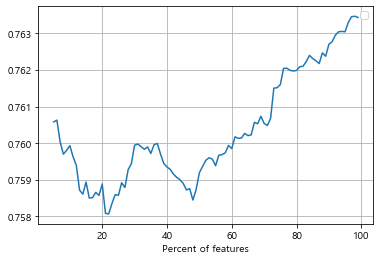

In [69]:
models = [logreg]


# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임
for model in models:
    
    cv_scores = []
    
    # 퍼센타일을 5~100프로 모두 살피기 <- 처음에만 100프로 찍고 이후 조절하기
    for percentile in tqdm(range(5,100)):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train,y_train)
       
        # cross_val_score 4번의 평균값 (정수시 skf로 자동으로 들어간다)
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=skf).mean()
        
        cv_scores.append((percentile, cv_score))
        
    # 베스트 percentile과 점수 출력
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

구간 작게 찍어서 최적의 p 뽑기

In [ ]:
new_range = []

# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임
for model in models:
    
    cv_scores = []
    
    # 다른 모델들 과적합 안나면서 성능도 평균적으로 좋은 부분으로 최종채택
    for percentile in tqdm(new_range):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train,y_train)
       
        # cross_val_score 4번의 평균값 (정수시 skf로 자동으로 들어간다)
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=skf)
        
        cv_scores.append((percentile, cv_score.mean()))
        
    # 베스트 percentile과 점수 출력
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(model.__class__.__name__, cv_score)
    print(best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

In [72]:
X_test = X_test.fillna({'goods_0_similarity':np.mean(X_test['goods_0_similarity']), 'goods_1_similarity':np.mean(X_test['goods_1_similarity'])})

In [70]:
select_p = SelectPercentile(percentile= 98).fit(X_train, y_train)
X_train = select_p.transform(X_train)
X_test = select_p.transform(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [74]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180
0,5.899665e-02,5.280996e-02,4.896489e-02,4.692144e-02,5.887605e-02,3.703730e-02,4.528708e-02,0.056775,4.558063e-02,4.952119e-02,5.959244e-02,4.511775e-02,5.462449e-02,4.705761e-02,0.061487,5.883342e-02,2.512778e-02,4.515208e-02,4.507128e-02,0.050417,0.037349,4.976974e-02,4.951488e-02,3.703742e-02,4.567186e-02,...,-0.134003,-0.113941,-0.009877,-0.050500,-0.000547,-0.122575,-0.141444,-0.132639,-0.108260,-0.120854,-0.149144,-0.071311,-0.115175,-0.067119,-0.140706,-0.156888,-0.105949,-0.155277,-0.097476,0.177814,0.056659,0.250375,0.015539,0.103248,-0.034322
1,4.440968e-02,3.742162e-02,5.923415e-02,2.783321e-02,2.523422e-02,7.106267e-03,3.267865e-02,0.005263,2.856833e-02,7.226545e-02,2.235206e-02,9.817278e-03,2.250186e-02,1.426914e-02,0.024142,2.960102e-02,2.988188e-02,1.449286e-02,5.052224e-02,0.012466,0.006994,1.225173e-03,3.484410e-02,7.933024e-02,5.527479e-02,...,-0.134003,-0.043292,-0.004148,-0.013518,-0.000547,-0.122575,-0.083895,-0.006223,-0.072234,0.009968,-0.049314,-0.069718,-0.115175,-0.027768,-0.055288,-0.156888,-0.077582,-0.129688,-0.097476,-0.178935,0.045230,-0.403775,0.367147,-0.165190,0.053595
2,3.381081e-02,8.462013e-03,8.081478e-02,3.126807e-03,3.733460e-02,4.156350e-02,6.252491e-02,0.003031,3.383411e-02,2.499662e-02,1.678573e-02,1.322571e-02,1.331047e-02,1.990806e-02,0.026797,4.470570e-02,5.285054e-03,3.717316e-02,9.725036e-03,0.000963,0.000839,7.777274e-03,4.730411e-02,2.759685e-03,2.173524e-02,...,-0.060017,-0.011618,0.032686,-0.020462,0.038383,-0.084510,-0.056942,-0.072221,-0.014983,-0.102819,-0.053004,0.066322,-0.069750,-0.038525,-0.066701,-0.007472,-0.013615,-0.054837,-0.013450,-0.432448,0.273241,0.068090,0.392857,-0.038744,0.191552
3,4.476567e-02,3.724468e-02,6.270374e-02,3.711123e-02,4.323265e-02,3.776972e-02,3.849525e-02,0.041409,2.866256e-02,4.330871e-02,5.383167e-02,3.393687e-02,4.525302e-02,2.844671e-02,0.029419,5.589782e-02,2.943322e-02,3.370453e-02,3.045639e-02,0.040457,0.046573,4.675895e-02,2.942423e-02,4.083059e-02,3.134383e-02,...,-0.086869,-0.044628,-0.001354,-0.061431,-0.029203,-0.051993,-0.074514,-0.153757,-0.085044,-0.031864,-0.150555,-0.012360,-0.158937,-0.065705,-0.140706,-0.168466,-0.090018,-0.140302,-0.138996,0.249025,0.071677,0.290123,0.167954,0.145361,0.077248
4,6.251881e-02,2.899562e-02,1.460668e-02,6.149970e-02,4.184485e-02,5.260567e-02,4.462630e-02,0.063573,3.777427e-02,4.822346e-02,6.022044e-02,2.236826e-02,2.380999e-02,1.820231e-02,0.046688,5.210932e-02,1.958533e-02,2.550013e-02,1.182246e-02,0.022583,0.020502,5.179163e-02,5.374951e-02,2.011977e-02,7.367784e-02,...,-0.060017,-0.024177,0.028466,-0.072115,-0.016811,-0.007957,-0.059653,-0.072221,-0.066115,-0.067482,-0.149144,0.023247,-0.137172,-0.038525,-0.066701,-0.090533,-0.098720,-0.181164,-0.156407,0.145374,0.031926,0.343873,-0.101595,0.084465,-0.067709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4.867327e-03,1.004821e-02,1.841670e-03,1.046062e-02,1.225543e-02,3.247649e-02,3.132902e-03,0.016049,3.362139e-02,8.664630e-02,6.594805e-03,1.763941e-02,5.992286e-02,1.350976e-02,0.029732,2.829801e-02,7.291049e-03,9.632668e-03,1.842618e-02,0.045679,0.010909,1.522550e-03,1.179132e-02,1.487208e-02,5.360587e-03,...,-0.107622,-0.050094,0.062155,-0.020462,0.049505,-0.117031,-0.113334,-0.072221,-0.056760,0.002338,-0.053004,0.012324,-0.069750,-0.038525,-0.066701,-0.051577,-0.028605,-0.021961,-0.013450,-0.134686,-0.004379,0.222717,0.121438,0.043792,0.042025
3496,4.646836e-02,7.465217e-02,3.738804e-02,2.867129e-02,2.526517e-02,2.221231e-02,5.093722e-02,0.046614,3.622800e-02,5.158681e-02,8.424698e-02,1.986091e-02,6.063771e-02,7.796669e-02,0.050515,5.133567e-02,3.175574e-02,3.903417e-02,5.288789e

In [76]:
pd.DataFrame(X_train).to_csv('X_train_after_percentile_nm&mclas2.csv',index=False,encoding='cp949')
pd.DataFrame(X_test).to_csv('X_test_after_percentile_nm&mclas2.csv',index=False,encoding='cp949')

피쳐에 대해서 기본성능보기   
 -> 여기서 cross_val_score 하였는데 기본성능 편차가 너무 크면 피쳐 재고려   
 -> 괜찮거나 튜닝 이후 괜찮을 것 같으면 진행

In [77]:
X_train = pd.read_csv('X_train_after_percentile_nm&mclas2.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_percentile_nm&mclas2.csv', encoding='cp949')

In [78]:
# 위에랑 피쳐 같은지 확인하고 진행
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180
0,5.899665e-02,5.280996e-02,4.896489e-02,4.692144e-02,5.887605e-02,3.703730e-02,4.528708e-02,0.056775,4.558063e-02,4.952119e-02,5.959244e-02,4.511775e-02,5.462449e-02,4.705761e-02,0.061487,5.883342e-02,2.512778e-02,4.515208e-02,4.507128e-02,0.050417,0.037349,4.976974e-02,4.951488e-02,3.703742e-02,4.567186e-02,...,-0.134003,-0.113941,-0.009877,-0.050500,-0.000547,-0.122575,-0.141444,-0.132639,-0.108260,-0.120854,-0.149144,-0.071311,-0.115175,-0.067119,-0.140706,-0.156888,-0.105949,-0.155277,-0.097476,0.177814,0.056659,0.250375,0.015539,0.103248,-0.034322
1,4.440968e-02,3.742162e-02,5.923415e-02,2.783321e-02,2.523422e-02,7.106267e-03,3.267865e-02,0.005263,2.856833e-02,7.226545e-02,2.235206e-02,9.817278e-03,2.250186e-02,1.426914e-02,0.024142,2.960102e-02,2.988188e-02,1.449286e-02,5.052224e-02,0.012466,0.006994,1.225173e-03,3.484410e-02,7.933024e-02,5.527479e-02,...,-0.134003,-0.043292,-0.004148,-0.013518,-0.000547,-0.122575,-0.083895,-0.006223,-0.072234,0.009968,-0.049314,-0.069718,-0.115175,-0.027768,-0.055288,-0.156888,-0.077582,-0.129688,-0.097476,-0.178935,0.045230,-0.403775,0.367147,-0.165190,0.053595
2,3.381081e-02,8.462013e-03,8.081478e-02,3.126807e-03,3.733460e-02,4.156350e-02,6.252491e-02,0.003031,3.383411e-02,2.499662e-02,1.678573e-02,1.322571e-02,1.331047e-02,1.990806e-02,0.026797,4.470570e-02,5.285054e-03,3.717316e-02,9.725036e-03,0.000963,0.000839,7.777274e-03,4.730411e-02,2.759685e-03,2.173524e-02,...,-0.060017,-0.011618,0.032686,-0.020462,0.038383,-0.084510,-0.056942,-0.072221,-0.014983,-0.102819,-0.053004,0.066322,-0.069750,-0.038525,-0.066701,-0.007472,-0.013615,-0.054837,-0.013450,-0.432448,0.273241,0.068090,0.392857,-0.038744,0.191552
3,4.476567e-02,3.724468e-02,6.270374e-02,3.711123e-02,4.323265e-02,3.776972e-02,3.849525e-02,0.041409,2.866256e-02,4.330871e-02,5.383167e-02,3.393687e-02,4.525302e-02,2.844671e-02,0.029419,5.589782e-02,2.943322e-02,3.370453e-02,3.045639e-02,0.040457,0.046573,4.675895e-02,2.942423e-02,4.083059e-02,3.134383e-02,...,-0.086869,-0.044628,-0.001354,-0.061431,-0.029203,-0.051993,-0.074514,-0.153757,-0.085044,-0.031864,-0.150555,-0.012360,-0.158937,-0.065705,-0.140706,-0.168466,-0.090018,-0.140302,-0.138996,0.249025,0.071677,0.290123,0.167954,0.145361,0.077248
4,6.251881e-02,2.899562e-02,1.460668e-02,6.149970e-02,4.184485e-02,5.260567e-02,4.462630e-02,0.063573,3.777427e-02,4.822346e-02,6.022044e-02,2.236826e-02,2.380999e-02,1.820231e-02,0.046688,5.210932e-02,1.958533e-02,2.550013e-02,1.182246e-02,0.022583,0.020502,5.179163e-02,5.374951e-02,2.011977e-02,7.367784e-02,...,-0.060017,-0.024177,0.028466,-0.072115,-0.016811,-0.007957,-0.059653,-0.072221,-0.066115,-0.067482,-0.149144,0.023247,-0.137172,-0.038525,-0.066701,-0.090533,-0.098720,-0.181164,-0.156407,0.145374,0.031926,0.343873,-0.101595,0.084465,-0.067709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4.867327e-03,1.004821e-02,1.841670e-03,1.046062e-02,1.225543e-02,3.247649e-02,3.132902e-03,0.016049,3.362139e-02,8.664630e-02,6.594805e-03,1.763941e-02,5.992286e-02,1.350976e-02,0.029732,2.829801e-02,7.291049e-03,9.632668e-03,1.842618e-02,0.045679,0.010909,1.522551e-03,1.179132e-02,1.487208e-02,5.360587e-03,...,-0.107622,-0.050094,0.062155,-0.020462,0.049505,-0.117031,-0.113334,-0.072221,-0.056760,0.002338,-0.053004,0.012324,-0.069750,-0.038525,-0.066701,-0.051577,-0.028605,-0.021961,-0.013450,-0.134686,-0.004379,0.222717,0.121438,0.043792,0.042025
3496,4.646836e-02,7.465217e-02,3.738804e-02,2.867129e-02,2.526517e-02,2.221231e-02,5.093722e-02,0.046614,3.622800e-02,5.158681e-02,8.424698e-02,1.986091e-02,6.063771e-02,7.796669e-02,0.050515,5.133567e-02,3.175574e-02,3.903417e-02,5.288789e

In [79]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
gbm = GradientBoostingClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0, n_jobs=-1)

models = [logreg, rf, gbm, lgbm]

In [80]:
# 모델별로 총 8개의 모델로 기본성능을 보고 평균적인 성능을 예측한다.

for model in models:
    
    lucky_seed = [2016, 2533]
    
    cv_scores = []
    
    for rs in lucky_seed:
        
        skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=rs)
        
        scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv = skf)
        
        cv_scores.append(scores)
        
    print(f'{model.__class__.__name__}, \ncv성능들: {cv_scores}\n최고성능: {max([score for scoreArr in cv_scores for score in scoreArr])}\n평균성능: {np.mean(cv_scores)}\n')

LogisticRegression, 
cv성능들: [array([0.77613369, 0.75742899, 0.75295323, 0.76620796]), array([0.76068005, 0.78232128, 0.74428839, 0.77048053])]
최고성능: 0.7823212754823697
평균성능: 0.7638117644766581

RandomForestClassifier, 
cv성능들: [array([0.7339507 , 0.73284568, 0.73553169, 0.73355267]), array([0.70749413, 0.73096407, 0.71002706, 0.74195308])]
최고성능: 0.7419530823786142
평균성능: 0.7282898838749903

GradientBoostingClassifier, 
cv성능들: [array([0.76946458, 0.75206253, 0.75768785, 0.75671922]), array([0.74599185, 0.76618847, 0.74270739, 0.75396083])]
최고성능: 0.7694645779752163
평균성능: 0.7555978406092388

LGBMClassifier, 
cv성능들: [array([0.74844963, 0.7325061 , 0.74351181, 0.73368906]), array([0.73631662, 0.74944331, 0.72972544, 0.74519579])]
최고성능: 0.7494433125132213
평균성능: 0.7398547184831379



##  Ensemble

In [81]:
# 튜닝 진행하며 미리 init_points=20, n_iter=10 으로 때려보고 파라미터 조절해가며 최고성능 더 끌어내기
# 파라미터 조절이후 지속적으로 안정적인 성능이 나오면 50,50 안때려도 됨. 50,50은 파라미터 튜닝 귀찮을때

BO_tuned_clfs = []

### Basian LR

In [88]:
# 하이퍼 파라미터 범위

pbounds = { 'C': (0.6,1.0),}


def logreg_opt(C):
    
    params = {
        'C' : C
    }

    logreg = LogisticRegression(**params, n_jobs=-1, random_state=50)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)
    
    score = cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)


BO_logreg = BayesianOptimization(f = logreg_opt, pbounds = pbounds, random_state=0)

In [89]:
BO_logreg.maximize(init_points=40, n_iter=10)

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.7632   |  0.8195   |
|  2        |  0.7632   |  0.8861   |
|  3        |  0.7632   |  0.8411   |
|  4        |  0.7632   |  0.818    |
|  5        |  0.7634   |  0.7695   |
|  6        |  0.7632   |  0.8584   |
|  7        |  0.7634   |  0.775    |
|  8        |  0.7632   |  0.9567   |
|  9        |  0.7632   |  0.9855   |
|  10       |  0.7633   |  0.7534   |
|  11       |  0.7632   |  0.9167   |
|  12       |  0.7633   |  0.8116   |
|  13       |  0.7632   |  0.8272   |
|  14       |  0.7632   |  0.9702   |
|  15       |  0.7633   |  0.6284   |
|  16       |  0.7633   |  0.6349   |
|  17       |  0.7633   |  0.6081   |
|  18       |  0.7632   |  0.933    |
|  19       |  0.7632   |  0.9113   |
|  20       |  0.7632   |  0.948    |
|  21       |  0.7632   |  0.9914   |
|  22       |  0.7632   |  0.9197   |
|  23       |  0.7634   |  0.7846   |
|  24       |  0.7632   |  0.9122   |
|  25       

In [90]:
# BO_rf.res  # 모든 성능 들어가있음
BO_logreg.max

{'target': 0.7633869423383101, 'params': {'C': 0.775034884505077}}

In [91]:
max_params = BO_logreg.max['params']

max_params

{'C': 0.775034884505077}

In [92]:

logreg_clf = LogisticRegression(**max_params,  n_jobs=-1, random_state=50)

scores = cross_val_score(logreg_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((logreg_clf.__class__.__name__, logreg_clf, max(scores)))

[0.76154292 0.78207633 0.74448879 0.77085908]
최대성능: 0.7820763329881871
평균성능: 0.7647417805092578


### Basian RF

In [93]:
# 하이퍼 파라미터 범위

pbounds = { 'n_estimators': (200,260),
            'max_depth': (5,15), 
            'max_features': (0.8,0.95),
            'min_samples_leaf': (1, 5)}

def rf_opt(n_estimators, max_depth, max_features, min_samples_leaf):
    
    params = {
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }

    rf = RandomForestClassifier(**params, n_jobs=-1, random_state=50)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)
    
    score = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)


BO_rf = BayesianOptimization(f = rf_opt, pbounds = pbounds, random_state=0)

In [94]:
BO_rf.maximize(init_points=20, n_iter=10)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.7561   |  10.49    |  0.9073   |  3.411    |  232.7    |
|  2        |  0.7553   |  9.237    |  0.8969   |  2.75     |  253.5    |
|  3        |  0.7559   |  14.64    |  0.8575   |  4.167    |  231.7    |
|  4        |  0.7513   |  10.68    |  0.9388   |  1.284    |  205.2    |
|  5        |  0.7587   |  5.202    |  0.9249   |  4.113    |  252.2    |
|  6        |  0.7513   |  14.79    |  0.9199   |  2.846    |  246.8    |
|  7        |  0.7587   |  6.183    |  0.896    |  1.573    |  256.7    |
|  8        |  0.7553   |  10.22    |  0.8622   |  2.058    |  246.5    |
|  9        |  0.7548   |  9.562    |  0.8853   |  1.075    |  237.1    |
|  10       |  0.7553   |  11.12    |  0.8925   |  4.775    |  240.9    |
|  11       |  0.7569   |  8.595    |  0.8656   |  3.791    |  203.6    |
|  12       |  0.753    |  11.67    | 

In [95]:
# BO_rf.res  # 모든 성능 들어가있음
BO_rf.max

{'target': 0.7590726143157754,
 'params': {'max_depth': 6.589695836455197,
  'max_features': 0.8165562711746458,
  'min_samples_leaf': 3.6253183578610937,
  'n_estimators': 208.29097708091683}}

In [96]:
max_params = BO_rf.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))

max_params

{'max_depth': 7,
 'max_features': 0.8165562711746458,
 'min_samples_leaf': 4,
 'n_estimators': 208}

In [97]:
rf_clf = RandomForestClassifier(**max_params,  n_jobs=-1, random_state=50)

scores = cross_val_score(rf_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((rf_clf.__class__.__name__, rf_clf, max(scores)))

[0.74595567 0.77298841 0.74563835 0.76903036]
최대성능: 0.7729884097665252
평균성능: 0.7584031976129241


### Basian LGBM

In [98]:
pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (90, 150),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'colsample_bytree': (0.75,0.9),   
            'num_leaves': (2,10),
            'min_child_weight': (1, 7)}


def lgbm_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    lgbm = LGBMClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=1)    


In [99]:
BO_lgbm.maximize(init_points=20, n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.6821   |  0.8126   |  1.094    |  3.001    |  2.814    |  98.81    |  2.739    |  0.8279   |
|  2        |  0.71     |  0.8018   |  0.6253   |  6.772    |  3.515    |  131.1    |  3.636    |  0.9317   |
|  3        |  0.6933   |  0.7541   |  1.022    |  5.921    |  4.352    |  98.42    |  3.585    |  0.9201   |
|  4        |  0.7213   |  0.8952   |  0.5045   |  7.846    |  6.258    |  143.7    |  2.68     |  0.8059   |
|  5        |  0.6826   |  0.7755   |  1.323    |  3.688    |  3.527    |  147.5    |  6.265    |  0.9038   |
|  6        |  0.702    |  0.7973   |  1.045    |  8.842    |  1.11     |  135.0    |  9.911    |  0.9122   |
|  7        |  0.666    |  0.7921   |  1.194    |  3.723    |  3.687    |  144.5    |  4.349    |  0.8432   |
|  8      

In [100]:
# BO_rf.res  # 모든 성능 들어가있음
BO_lgbm.max

{'target': 0.7647605687119365,
 'params': {'colsample_bytree': 0.827829197902785,
  'learning_rate': 0.05643617443420437,
  'max_depth': 3.320025295400751,
  'min_child_weight': 1.4729840981523845,
  'n_estimators': 115.15567036672712,
  'num_leaves': 9.825904107240458,
  'subsample': 0.811514703507804}}

In [101]:
max_params = BO_lgbm.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['num_leaves'] = int(round(max_params['num_leaves']))

max_params

{'colsample_bytree': 0.827829197902785,
 'learning_rate': 0.05643617443420437,
 'max_depth': 3,
 'min_child_weight': 1.4729840981523845,
 'n_estimators': 115,
 'num_leaves': 10,
 'subsample': 0.811514703507804}

In [102]:
lgbm_clf = LGBMClassifier(**max_params)

scores = cross_val_score(lgbm_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((lgbm_clf.__class__.__name__, lgbm_clf, max(scores)))

[0.75004453 0.77001848 0.74611432 0.76115602]
최대성능: 0.7700184820245611
평균성능: 0.7568333389002082


### Basian GB

In [ ]:
pbounds = { 'learning_rate': (0.05, 1.5),
            'n_estimators': (50, 250),
            'max_depth': (3,10),   
            'subsample': (0.8,0.95), 
            'min_samples_split': (2,5),   
            'min_samples_leaf': (1,5)}


def gb_opt(learning_rate, n_estimators, max_depth, subsample, min_samples_split, min_samples_leaf):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'min_samples_split' : int(round(min_samples_split)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }
    
    gb = GradientBoostingClassifier(**params)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

    score = cross_val_score(gb, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)

BO_gb = BayesianOptimization(f = gb_opt, pbounds = pbounds, random_state=0)    


In [ ]:
BO_gb.maximize(init_points=20, n_iter=10)

In [ ]:
# BO_rf.res  # 모든 성능 들어가있음
BO_gb.max

In [ ]:
max_params = BO_gb.max['params']

max_params['n_estimators'] = int(round(max_params['n_estimators']))
max_params['max_depth'] = int(round(max_params['max_depth']))
max_params['min_samples_leaf'] = int(round(max_params['min_samples_leaf']))
max_params['min_samples_split'] = int(round(max_params['min_samples_split']))

max_params

In [ ]:
gb_clf = GradientBoostingClassifier(**max_params)

scores = cross_val_score(gb_clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((gb_clf.__class__.__name__, gb_clf, max(scores)))

In [103]:
gb_clf = gbm = GradientBoostingClassifier(random_state=0)

scores = cross_val_score(gb_clf, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

BO_tuned_clfs.append((gb_clf.__class__.__name__, gb_clf, max(scores)))

[0.74599185 0.76618847 0.74270739 0.75396083]
최대성능: 0.7661884721155238
평균성능: 0.7522121369005869


In [104]:
BO_tuned_clfs

[('LogisticRegression',
  LogisticRegression(C=0.775034884505077, class_weight=None, dual=False,
                     fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=50, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False),
  0.7820763329881871),
 ('RandomForestClassifier',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=7,
                         max_features=0.8165562711746458, max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=4,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=208, n_jobs=-1, oob_score=False,
                         random_state=50, verbose=0, warm_start=False),
  0.7729884097665252),
 ('LGBMClassifier',
  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                 colsample_bytree=0.827829197902785, importance_type='split',
                 learning_rate=0.05643617443420437, max_depth=3,
                 min_child_samples=20, min_child_weight=1.4729840981523845,
                 min_split_gain=0.0, n_estimators=115, n_jobs=-1, num_leaves=10,
                 objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
                 silent=True, subsample=0.811514703507804,
                 subsample_for_bin=200000, subsample_freq=0),
  0.7700184820245611),
 ('GradientBoostingClassifier',
  GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                             learning_rate=0.1, loss='deviance', max_depth=3,
                             max_features=None, max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_estimators=100,
                             n_iter_no_change=None, presort='deprecated',
                             random_state=0, subsample=1.0, tol=0.0001,
                             validation_fraction=0.1, verbose=0,
                             warm_start=False),
  0.7661884721155238)]

In [105]:
len(BO_tuned_clfs)

4

### *Averaging Ensemble*

In [106]:
estimators = BO_tuned_clfs.copy()

In [107]:
estimators = [estimators[i][1] for i in range(len(estimators))]

In [108]:
skf = StratifiedKFold(n_splits=4 , shuffle=True, random_state=0)

models = estimators

pred_probas = []

for model in models:
    
    for train_index, test_index in skf.split(X_train, y_train):
    
        x_tra, x_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tra, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
        pred = model.fit(x_tra, y_tra).predict_proba(x_val)[:,1]
    
        print(roc_auc_score(y_val, pred))
        
    print(model.__class__.__name__)
    
    pred_probas.append(model.predict_proba(X_test)[:,1])


0.7648663393344244
0.7636805949875858
0.7623779462685238
0.76300421969115
LogisticRegression
0.762661856886781
0.7596696616453456
0.7601177950722023
0.7594386363383323
RandomForestClassifier
0.7725708941514413
0.7623389781444494
0.7709704176269526
0.7620216662769854
LGBMClassifier
0.7555056392442411
0.7542586592738568
0.758717726042954
0.7512887315318926
GradientBoostingClassifier


In [ ]:
0.7635302893661556
0.7522016990102098
0.7650166449558546
0.7588624647895165
LogisticRegression
0.7717553469833104
0.7633159646837459
0.7680533751962324
0.7607579856819978
RandomForestClassifier
0.7832091920237816
0.7656568355656501
0.7642233652871951
0.7729104735183762
LGBMClassifier
0.778555284634312
0.7613369406682476
0.7686128461204449
0.7631962768740884
GradientBoostingClassifier

In [109]:
# 기하평균

average_prediction = (pred_probas[0] * pred_probas[1] * pred_probas[2] * pred_probas[3]) ** (1/4)

In [110]:
# average_prediction = np.zeros(2482)

# for pred in pred_probas:
    
#     average_prediction += pred/len(models)


서브미션 파일 이름 조정

In [111]:
# averaging emsemble result

pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':average_prediction}).set_index('cust_id').to_csv('submission_nm&mclas2_w2v_avg.csv', index=True, encoding='cp949')

### *Ensemble Stacking*

In [112]:
stack_estimators = estimators

len(stack_estimators)

4

    - S_train, S_test transform

In [113]:
S_train, S_test = stacking(stack_estimators,
                           X_train, y_train, X_test,
                           regression=False, needs_proba=True, metric=None, n_folds=5, stratified=True, shuffle=True,
                           random_state=0, verbose=0)

Stacking - Meta_Model: LogReg

-> 피쳐별로 파라미터 범위 간단한 튜닝 필요할 수 있음

In [118]:
pbounds = { 'C': (0.2,.8),}



def logreg_meta(C):
    
    params = {
        'C' : C
    }

    logreg = LogisticRegression(**params, n_jobs=-1, random_state=50)
    
    skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)
    
    score = cross_val_score(logreg, S_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return np.mean(score)


BO_logreg = BayesianOptimization(f = logreg_meta, pbounds = pbounds, random_state=0)

In [119]:
BO_logreg.maximize(init_points=40, n_iter=20)


|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.7693   |  0.5293   |
|  2        |  0.7694   |  0.6291   |
|  3        |  0.7694   |  0.5617   |
|  4        |  0.7693   |  0.5269   |
|  5        |  0.7693   |  0.4542   |
|  6        |  0.7694   |  0.5875   |
|  7        |  0.7693   |  0.4626   |
|  8        |  0.7693   |  0.7351   |
|  9        |  0.7693   |  0.7782   |
|  10       |  0.7693   |  0.4301   |
|  11       |  0.7694   |  0.675    |
|  12       |  0.7693   |  0.5173   |
|  13       |  0.7693   |  0.5408   |
|  14       |  0.7693   |  0.7554   |
|  15       |  0.7694   |  0.2426   |
|  16       |  0.7694   |  0.2523   |
|  17       |  0.7693   |  0.2121   |
|  18       |  0.7694   |  0.6996   |
|  19       |  0.7694   |  0.6669   |
|  20       |  0.7693   |  0.722    |
|  21       |  0.7693   |  0.7872   |
|  22       |  0.7694   |  0.6795   |
|  23       |  0.7693   |  0.4769   |
|  24       |  0.7694   |  0.6683   |
|  25       

In [120]:
# BO_rf.res  # 모든 성능 들어가있음
BO_logreg.max

{'target': 0.769420042976274, 'params': {'C': 0.6291136198234517}}

In [121]:
max_params = BO_logreg.max['params']

max_params

{'C': 0.6291136198234517}

In [122]:

logreg_meta = LogisticRegression(**max_params,  n_jobs=-1, random_state=50)

scores = cross_val_score(logreg_meta, S_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

print(scores)
print(f'최대성능: {max(scores)}\n평균성능: {np.mean(scores)}')

[0.77928455 0.76624971 0.76792812 0.76298474]
최대성능: 0.7792845452419921
평균성능: 0.7691117772804703


In [123]:
S_train = pd.DataFrame(S_train)

model = logreg_meta
  
for train_index, test_index in skf.split(S_train, y_train):
    
    x_tra, x_val = S_train.iloc[train_index], S_train.iloc[test_index]
    y_tra, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    pred = model.fit(x_tra, y_tra).predict_proba(x_val)[:,1]
    
    print(roc_auc_score(y_val, pred))
        
print(model.__class__.__name__)
    
stack_prediction = model.predict_proba(S_test)[:,1]


0.7792845452419921
0.7662497077390695
0.7679281205117071
0.7629847356291125
LogisticRegression


서브미션 파일 이름 조정

In [124]:
# stacking emsemble result

pd.DataFrame({'cust_id':np.arange(3500,5982), 'gender':stack_prediction}).set_index('cust_id').to_csv('submission_nm&mclas2_stack.csv', index=True, encoding='cp949')

*******

<font color="#CC3D3D"><p>
# End